In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


# Clone github repo

In [1]:
# Clone the entire repo.
!git clone https://github.com/Tuan-Lee-23/Vietnamese-Reactionary-Article-Classification-.git
%cd Vietnamese-Reactionary-Article-Classification-/
!ls

Cloning into 'Vietnamese-Reactionary-Article-Classification-'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 185 (delta 4), reused 25 (delta 3), pack-reused 154
Receiving objects: 100% (185/185), 125.12 MiB | 20.41 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Checking out files: 100% (57/57), done.
/content/Vietnamese-Reactionary-Article-Classification-
analysis  data	demo  modeling	README.md


# Import Libs

In [2]:
import re
import seaborn as sns
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pickle
import plotly.express as px
import plotly.figure_factory as ff

tqdm.pandas()

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



# Import data from GDRIVE

In [3]:
%cd data/datasets/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data/datasets
0  1  README.md


In [4]:
dataset_1 = os.listdir(os.getcwd() + '/1/')
dataset_0 = os.listdir(os.getcwd() + '/0/')

dataset_1 =  sorted(dataset_1, reverse= True)

print(dataset_1)
print(dataset_0)


['viettan_quandiem.csv', 'viettan_org_4.csv', 'viettan_org_3.csv', 'viettan_org_2.csv', 'viettan_org.csv', 'viettan_hoatdong.csv', 'viettan_fb.csv', 'viettan_diendan_3.csv', 'viettan_diendan_2.csv', 'viettan_diendan_1.csv', 'thanhnienconggiao.csv', 'sbtn.csv', 'rfa.csv', 'khoi8406.csv', 'haudue_vnch.csv', 'chantroimoi_media.csv', 'bpsos.csv', 'PhamMinhVuFBd.csv', 'KhoaLuatTapChi_XaHoi.csv', 'KhoaLuatTapChi_VNCH.csv', 'KhoaLuatTapChi_ChinhTri.csv', 'GiaoChucChuVanAn.csv']
['vnexpress_thoisu_2.csv', 'tinnoichinh.csv', 'vnexpress_kinhdoanh.csv', 'qdnd_dienbienhoabinh.csv', 'vnexpress_phapluat.csv', 'vnexpress_thoisu_1.csv', 'qdnd_chinhtri.csv']


# Preprocessing

- [x]  Open csv
- [x]  Drop missing values
- [x]  Assign label for dataframe base on class
- [x]  Clean html
- [x]  Normalize unicode
- [x]  Remove long - short articles (len_limit)
- [x]  Remove hyperlinks
- [x]  Plot len distribution (3 type - pdf, ecdf, rug plot)
- [x]  Keep number, special character, punctuation since BERT can handle all of them
- [x]  Save as pickle (name)
- [x]  Read pickle (name)
- Keep number, special character, punctuation since BERT can handle them

In [6]:
class Dataframe:
    
    def __init__(self):
        self.directory = ''
        self.name = ''

        self.df = []
        self.label = 0


    def __init__(self, directory, label):
        self.name = directory
        self.directory = directory
        self.label = label
        self.df = []

    # read csv file and add label column
    def read_csv(self):
        df = pd.read_csv(os.getcwd() + self.directory)
        print("df: ", df)
        df = df.drop(['Unnamed: 0'], axis = 1)
        if 'blue' in df.columns:
            df.rename(columns = {'blue': 'content'}, inplace = True)
        
        if self.label:
            df['label'] = np.ones((df.shape)).astype('int')
        else:
            df['label'] = np.zeros((df.shape)).astype('int')
        df['label'].astype('category')
        df = df.dropna()
        df['avg_length'] = df['content'].apply(len)

        self.df = df
        

    def plot(self): #df
        plt.style.use('ggplot')
        plt.figure(figsize = (15, 10))

        sns.rugplot(self.df['avg_length'])
        plt.show()

        px.histogram(self.df['avg_length'])
        plt.show()

        sns.kdeplot(self.df['avg_length'])
        plt.show()

        sns.ecdfplot(self.df['avg_length'])
        plt.show()

        fig = ff.create_distplot([self.df['avg_length']], [''])
        fig.update_layout(title='Dist Plot')
        fig.show()



    def preprocess(self):
        def clean_html(raw_html): #text
            cleanr = re.compile('<.*?>')
            cleantext = re.sub(cleanr, '', raw_html)
            return cleantext

         # Normalize unicode
        def normalize_unicode(txt): # text
            def loaddicchar():
                dic = {}
                char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
                    '|')
                charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
                    '|')
                for i in range(len(char1252)):
                    dic[char1252[i]] = charutf8[i]
                return dic

            def convert_unicode(txt):
                dicchar = loaddicchar()
                return re.sub(
                    r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
                    lambda x: dicchar[x.group()], txt)
            return convert_unicode(txt)
                
         # Remove short articles
        def remove_short(limit): #df
            self.df = self.df[self.df['avg_length'] > limit]

        # Remove long articles
        def remove_long(limit): #df
            self.df = self.df[self.df['avg_length'] < limit]

        # Remove hyperlinks in text
        def remove_urls(input_text): #text
            return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

        # Normalize Vietnamese
        # def normalize_vietnamese():
            # self.df['content'] = self.df['content'].progress_apply(lambda x: TTSnorm(x, lower = False, punc = True))



        self.df['content'] = self.df['content'].apply(clean_html)
        self.df['content'] = self.df['content'].apply(normalize_unicode)
        self.df['content'] = self.df['content'].apply(remove_urls)

        limit = input('Enter < limit:')
        limit = int(limit)

        remove_short(limit)

        limit = input('Enter > limit:')
        limit = int(limit)

        remove_long(limit)
        # normalize_vietnamese()

        

    # Save dataframe to pickle file
    def save_preprocess(self, name):
        self.df.to_csv(name + '.csv')
 
    
def read_preprocess(name):
    temp = pd.read_pickle(name)
    return temp

# Perform on datasets

## Viettan

### Define new instances

In [7]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [8]:
viettan_ls = []

for i in [0, 1, 2, 3, 4, 5, 7, 8, 9]:
    test = Dataframe('/1/' + dataset_1[i], 1)
    print(test.name)
    test.read_csv()
    viettan_ls.append(test.df)

viettan= Dataframe('', 1)
viettan.df = pd.concat(viettan_ls)
df = viettan.df

print(df.shape)

/1/viettan_quandiem.csv
df:       Unnamed: 0                                            content
0             0  Việt Nam có nên tiếp tục “chống dịch như chống...
1             1  Nguyễn Phú Trọng và con đường tiến lên xã hội ...
2             2  Ngày 30 tháng 4\nThấm thoát biến cố 30 tháng 4...
3             3  Myanmar đứng trước nguy cơ nội chiến\nCuộc đảo...
4             4  Vai trò “trung tâm” của Nhật Bản trong chiến l...
..          ...                                                ...
351         351  Năm Mới — Tinh Thần Mới — Nỗ Lực Mới\nChúng ta...
352         352  Thái Độ Của Chúng Ta Trước Thảm Kịch Ngư Dân V...
353         353  Phá Vỡ Bức Tường Ngăn Cách\nTháng 11 vừa qua, ...
354         354  Thế Liên Minh Dân Tộc Hôm Nay\nLiên minh dân t...
355         355  Để Xây Dựng Nền Giáo Dục Việt Nam Hiện Đại\nI-...

[356 rows x 2 columns]
/1/viettan_org_4.csv
df:       Unnamed: 0                                            content
0             0  Phúc trình của CPJ về tình hình b

### Content Filter

In [9]:
temp = df[df['content'].str.contains("CS|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|công an|" + 
        "quan chức|cướp|nhà nước|tự do|dối|thất bại|bê bối|chính trị|chính quyền|XHCN", regex = True, flags=re.IGNORECASE)]

print(viettan.name)
viettan.df = temp
df = viettan.df

viettan.df

,content,label,avg_length
0,Việt Nam có nên tiếp tục “chống dịch như chống...,1,9109
1,Nguyễn Phú Trọng và con đường tiến lên xã hội ...,1,5084
2,Ngày 30 tháng 4\nThấm thoát biến cố 30 tháng 4...,1,4186
3,Myanmar đứng trước nguy cơ nội chiến\nCuộc đảo...,1,11835
4,Vai trò “trung tâm” của Nhật Bản trong chiến l...,1,5762
...,...,...,...
1245,Hàng chục người tham gia đồng hành tuyệt thực ...,1,4886
1246,Trần Huỳnh Duy Thức “Lửa Việt Cháy Trong Tù”\n...,1,4473
1247,Quốc khánh… cuối cùng?\n73 năm “Độc Lập – Tư...,1,11363
1248,‘Sáp nhập tiền tệ’ để tiến tới ‘sáp nhập lãnh ...,1,7291


In [10]:
df = viettan.df

df[df['content'].duplicated()]

,content,label,avg_length
12,Việt Nam có nên tiếp tục “chống dịch như chống...,1,9109
13,Nguyễn Phú Trọng và con đường tiến lên xã hội ...,1,5084
14,Ngày 30 tháng 4\nThấm thoát biến cố 30 tháng 4...,1,4186
15,Myanmar đứng trước nguy cơ nội chiến\nCuộc đảo...,1,11835
16,Vai trò “trung tâm” của Nhật Bản trong chiến l...,1,5762
...,...,...,...
332,Bộ Trưởng Ngoại Giao Úc trả lời Dân Biểu Chris...,1,2346
554,"Phỏng vấn Kỹ Sư Đỗ Hoàng Điềm, Chủ Tịch Đảng V...",1,8427
555,Chủ tịch Đảng Việt Tân: ‘Phải phá bỏ độc tài C...,1,7550
580,Cộng Đồng Úc thông báo chiến dịch vận động tự ...,1,3662


### Plot distribution

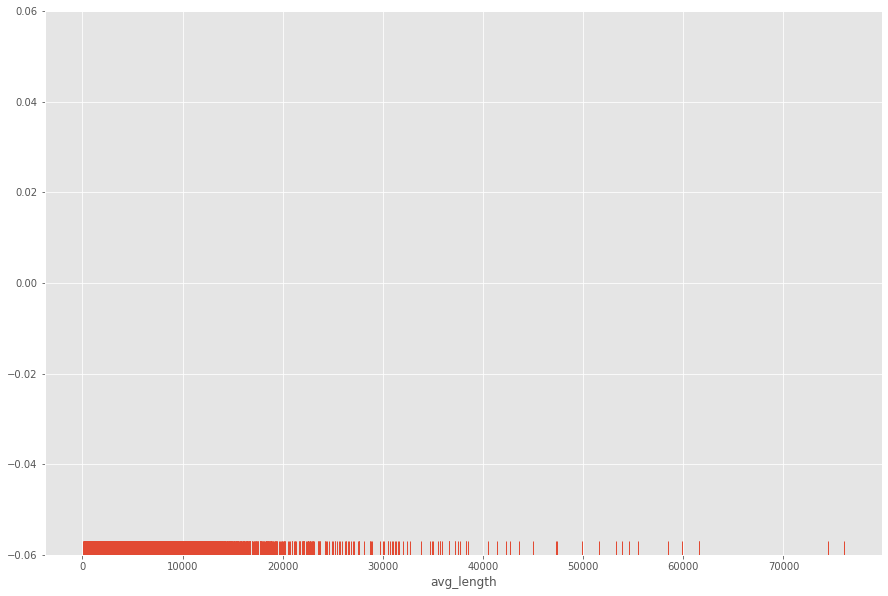

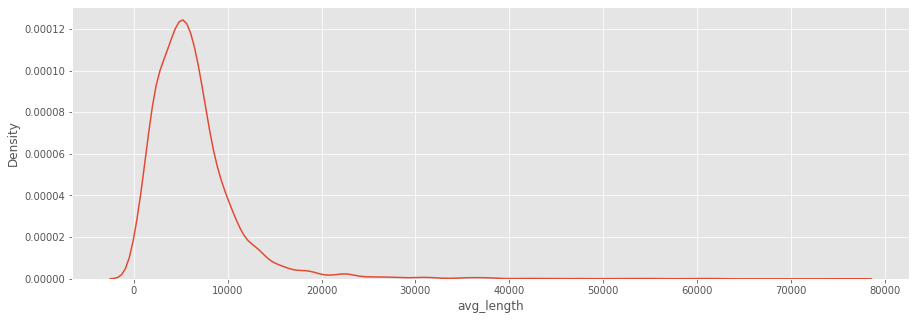

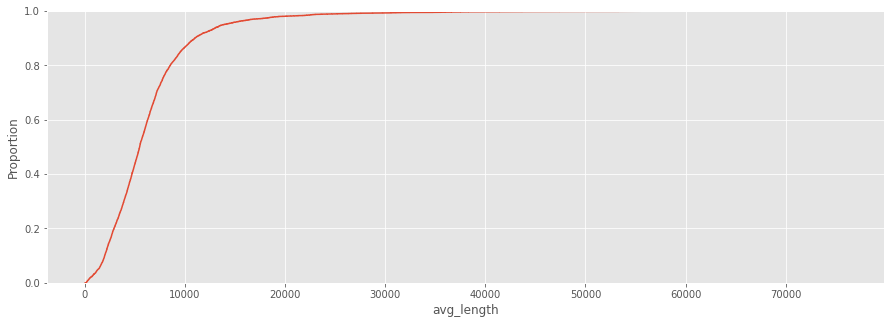

In [11]:
viettan.plot()

### Observations

In [12]:
limit = 750

In [13]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[-3])

116     Góc Nhìn Việt Tân: Viễn cảnh Việt Nam 2018\nKa...
208     Ông Lý Thái Hùng nhận định về lãnh đạo mới của...
55      Cấp báo của Toà giáo mục Xã Đoài\nCẤP BÁO\n20....
186     Biểu Tình Phản Đối Rước Đuốc Thế Vận Hội Bắc K...
41      Biểu tình ngày 19/6/2011 tại Sài Gòn và Hà Nội...
                              ...                        
1389    Ủy Ban Công Lý – Hòa Bình VN hiệp thông cùng G...
1393    Mừng Phương Uyên… nhớ Minh Hạnh\nSau khi sinh ...
1396    Đồng đội mừng sinh nhật Ls. Lê Quốc Quân\nSau ...
1432    Phim mới đang bị cấm: Truyền Đơn Kỳ Án\nHãng p...
532     Vòng hoa “mồ côi”\nVòng hoa của trang Bauxite ...
Name: content, Length: 181, dtype: object
--------------------



Đồng đội mừng sinh nhật Ls. Lê Quốc Quân
Sau đây là tâm tình của một số nhà dân chủ gởi Ls. Lê Quốc Quân nhân ngày sinh nhật thứ 42 của anh. Mời quí vị theo dõi (Nguồn lấy từ RadioCTM).
BBT-WebVT
TL-LQQuân


In [14]:
limit = 48000

In [15]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

196     220 Sự Kiện Nổi Bật Của Phong Trào Tranh Đấu D...
252     Tài liệu tố giác Nguyễn Chí Vịnh\nLời giới thi...
396     Không ai đoán được hiệu ứng Domino năm 1989*\n...
2137    Đọc tập sách “Chết Bởi Trung Quốc” của tác giả...
217     Luật Hiến pháp và Chính trị học (2)\nChương mở...
959     Những bất lợi lớn trong các dự án khai thác bô...
1067    Bài Bênh Vực Luật Sư Nguyễn Văn Đài Nhân Phiên...
1145    Cuộc Cách Mạng Dân Chủ Tại Ba Lan\nNhân kỷ niệ...
1151    Việt Nam: Bước Ra Thế Giới Cạnh Tranh\nBài viế...
1143    Lại nói về đồng minh\nViệc giàn khoan Haiyang ...
1407    Luật Hiến pháp và Chính trị học (2)\nChương mở...
424     Ôn lại một số đặc điểm trong lịch sử tị nạn Vi...
Name: content, dtype: object
--------------------



220 Sự Kiện Nổi Bật Của Phong Trào Tranh Đấu Dân Chủ Nhân Quyền Việt Nam Trong Năm 2007
Năm 2007 sắp trôi qua, trong năm 2007 các hoạt động tranh đấu dân chủ nhân quyền cho Việt Nam diễn ra sôi động khắp nơi ở trong nước và trên thế giới rất nhiều và 

### Run Preprocessing method

In [16]:
# 750 - 48000
# ...
viettan.preprocess()

Enter < limit:750
Enter > limit:48000


### Save

In [17]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	   viettan_fb.pickle
chantroimoi.pickle	 rfa.pickle		   viettan.pickle
giaochucchuvanan.pickle  sbtn.pickle
khoi8406.pickle		 thanhnienconggiao.pickle


In [18]:
viettan.save_preprocess(os.getcwd() + "/viettan")

In [19]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Viettan FB

### Define new instances

In [20]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

viettan_fb = Dataframe('/1/' + 'viettan_fb.csv', 1)
print(viettan_fb.name)
viettan_fb.read_csv()

df = viettan_fb.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/viettan_fb.csv
df:        Unnamed: 0                                            content
0              0  Bộ máy tuyên giáo CSVN luôn tuyên truyền về va...
1              1  BẮC KINH BỊ CÁO BUỘC DIỆT CHỦNG NGƯỜI NGÔ DUY ...
2              2  Sự bất công của ngành công an đang được bộc lộ...
3              3  5 NGƯỜI BỊ BẮT VÌ ĐƯA 200 NGƯỜI TRUNG QUỐC XUẤ...
4              4  BẦU CỬ NHƯ VIỆC NẤU ĂN\nLs Luân Lê\n\nKhi sự s...
...          ...                                                ...
1669        1669  NGHI NGỜ DÂN, SỢ DÂN, ĐCSVN DIỄN TẬP CHỐNG DÂN...
1670        1670  An Ninh Điện Tử - Bảo Mật Số\n\nWHATSAPP THÂU ...
1671        1671  Ý CHÍ SẮT ĐÁ VÀ HIẾU HỌC ĐÃ BIẾN NGƯỜI TÙ THÀN...
1672        1672  VIẾT VỀ NGƯỜI ÔNG ĐÁNG KÍNH CÓ TÊN...
1673        1673  VIỆT NAM CẦN THẨM PHÁN SUỐT ĐỜI?\n\nSáng, chợt...

[1674 rows x 2 columns]


,content,label,avg_length
0,Bộ máy tuyên giáo CSVN luôn tuyên truyền về va...,1,576
1,BẮC KINH BỊ CÁO BUỘC DIỆT CHỦNG NGƯỜI NGÔ DUY ...,1,701
2,Sự bất công của ngành công an đang được bộc lộ...,1,335
3,5 NGƯỜI BỊ BẮT VÌ ĐƯA 200 NGƯỜI TRUNG QUỐC XUẤ...,1,703
4,BẦU CỬ NHƯ VIỆC NẤU ĂN\nLs Luân Lê\n\nKhi sự s...,1,706
...,...,...,...
1669,"NGHI NGỜ DÂN, SỢ DÂN, ĐCSVN DIỄN TẬP CHỐNG DÂN...",1,702
1670,An Ninh Điện Tử - Bảo Mật Số\n\nWHATSAPP THÂU ...,1,693
1671,Ý CHÍ SẮT ĐÁ VÀ HIẾU HỌC ĐÃ BIẾN NGƯỜI TÙ THÀN...,1,705
1672,VIẾT VỀ NGƯỜI ÔNG ĐÁNG KÍNH CÓ TÊN...,1,697


### Content Filter

In [21]:
temp = df[df['content'].str.contains("VN|CS|Việt Nam|chính phủ|công an|đánh|tù|dân chủ|cộng sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|nhà nước|tự do|dối|bê bối|lực lượng|quan chức", regex = True, flags=re.IGNORECASE)]

viettan_fb.df = temp
viettan_fb.df

,content,label,avg_length
0,Bộ máy tuyên giáo CSVN luôn tuyên truyền về va...,1,576
1,BẮC KINH BỊ CÁO BUỘC DIỆT CHỦNG NGƯỜI NGÔ DUY ...,1,701
2,Sự bất công của ngành công an đang được bộc lộ...,1,335
3,5 NGƯỜI BỊ BẮT VÌ ĐƯA 200 NGƯỜI TRUNG QUỐC XUẤ...,1,703
4,BẦU CỬ NHƯ VIỆC NẤU ĂN\nLs Luân Lê\n\nKhi sự s...,1,706
...,...,...,...
1668,ĐỒNG TÂM – MỘT TẤM BIA GHI LẠI TỘI ÁC CS THỜI ...,1,701
1669,"NGHI NGỜ DÂN, SỢ DÂN, ĐCSVN DIỄN TẬP CHỐNG DÂN...",1,702
1671,Ý CHÍ SẮT ĐÁ VÀ HIẾU HỌC ĐÃ BIẾN NGƯỜI TÙ THÀN...,1,705
1672,VIẾT VỀ NGƯỜI ÔNG ĐÁNG KÍNH CÓ TÊN...,1,697


### Plot distribution

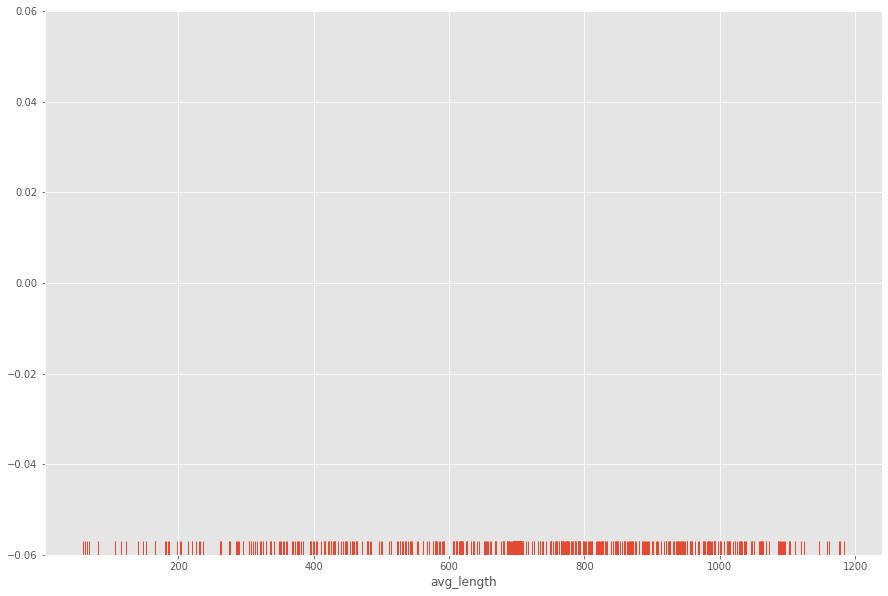

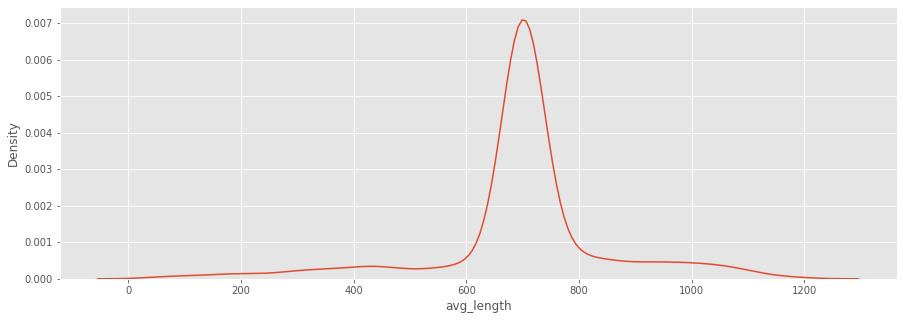

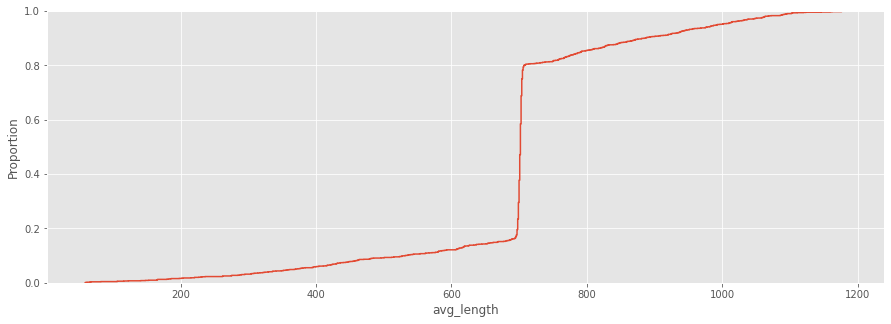

In [22]:
viettan_fb.plot()

### Observations

In [23]:
limit = 350

In [24]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[3])

2       Sự bất công của ngành công an đang được bộc lộ...
14      Sự khác biệt giữa công an trên tivi và công an...
19      Bạn nghĩ gì vè cách thức tuyên truyền nay?\n\n...
30      Không cần phải đầu tư trang phục kỳ công, vượt...
36      CÓ NHỮNG HI SINH THẦM LẶNG, TÔ ĐẸP CHO ĐỜI ❤\n...
                              ...                        
1595    DANH CA LỆ THU ĐÃ RA ĐI VÌ COVID-19\n\nNữ danh...
1601    Hai Tiến sĩ của nước CHXHCN Việt Nam chuyên bu...
1635    TỐN BAO NHIÊU TIỀN CHO CHIẾC XE MÀ CÁC ĐỒNG CH...
1657    Ông Tô Lâm làm Bộ trưởng Bộ Công an không lo t...
1662    Tròn một năm tang tóc cho dân làng Đồng Tâm nó...
Name: content, Length: 113, dtype: object
--------------------



Không cần phải đầu tư trang phục kỳ công, vượt qua 73 đối thủ, Thuzar Wint Lwin đã chính thức thắng giải "Trang phục dân tộc", chỉ với một tờ giấy nhỏ, một ánh mắt buồn.

Trích Facebook Đỗ cao Cường


In [25]:
limit = 1120

In [26]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

13      TẠI SAO ĐCSVN NHẤT ĐỊNH PHẢI BẮT DÂN ĐI BỎ PHI...
279     ẢNH HƯỞNG GIA TĂNG CỦA QUÂN ĐỘI TRONG CHÍNH TR...
570     PHẠM MINH CHÍNH THAM VỌNG GHẾ TỔNG BÍ THƯ CỦA ...
939     TIẾT LỘ DANH SÁCH DỰ KIẾN NHÂN SỰ LÃNH ĐẠO CÁC...
1418    Trung quốc kiểm soát chính trị Việt Nam: Phạm ...
1556    Bộ chính trị phá vỡ nhiều chuẩn tắc trong sắp ...
1641    Danh sách "tứ trụ" Đại hội 13: cân bằng thế lự...
Name: content, dtype: object
--------------------



TẠI SAO ĐCSVN NHẤT ĐỊNH PHẢI BẮT DÂN ĐI BỎ PHIẾU BẦU CỬ QUỐC HỘI?

Tại Việt Nam, người ta luôn cảm thấy tức cười khi nghĩ tới chuyện bầu cử. Bất kỳ cuộc bầu cử nào, từ cấp trung ương cho đến cấp địa phương, hầu hết đều cho thấy tính khôi hài. Bởi dân chưa bầu thì người ta đã biết ông nào làm vị trí nào, bà nào ngồi ghế nào và chuyện dân đi bầu chỉ là chuyện trò cười của các ông bà. Bởi cho dù có hàng triệu người gạch bỏ cái tên nào đó thì tỉ lệ phiếu bầu của nó vẫn 100% đắc cử, tín nhiệm. Bởi chuyện bầu bán ở đây không có ý nghĩa nào v

### Run Preprocessing method

In [27]:
# 350 - 50000
# ...
viettan_fb.preprocess()

Enter < limit:350
Enter > limit:50000


### Save

In [28]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	   viettan.csv
chantroimoi.pickle	 rfa.pickle		   viettan_fb.pickle
giaochucchuvanan.pickle  sbtn.pickle		   viettan.pickle
khoi8406.pickle		 thanhnienconggiao.pickle


In [29]:
viettan_fb.save_preprocess(os.getcwd() + "/viettan_fb")

In [30]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Thanh nien cong giao

### Define new instances

In [31]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

thanhniencongiao = Dataframe('/1/' + 'thanhnienconggiao.csv', 1)
print(thanhniencongiao.name)
thanhniencongiao.read_csv()

df = thanhniencongiao.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/thanhnienconggiao.csv
df:        Unnamed: 0                                            content
0              0  “Nếu linh hồn thuộc về nhà nước, thì việc dâng...
1              1  MUỐN VÀO NƯỚC TRỜI HÃY NÊN NHƯ TRẺ NHỎ\n\nLòng...
2              2  MƯỜI CĂN BỆNH LÀM BĂNG HOẠI NGƯỜI CÔNG GIÁO\n(...
3              3  BẢN TIN ĐẶC BIỆT VỀ NỮ TÙ NHÂN LƯƠNG TÂM VIỆT ...
4              4  Bộ máy nhà nước Việt Nam hiện tại có khoảng 3 ...
...          ...                                                ...
5507        5507  TẠI XÃ DIỄN MỸ NGÀY 30/10, CÔNG AN DÀY ĐẶC ĐỂ ...
5508        5508  NHỮNG BÊ BỐI Ở TRẠI GIAM NGHĨA AN - QUẢNG TRỊ ...
5509        5509  BẰNG CHỨNG CỜ ĐỎ DIỄN MỸ ĐÁNH NGƯỜI\n\n#TNCG -...
5510        5510  CÂY CẦU CHO XỨ NGHÈO VÙNG NÚI\n#TNCG - Giáo xứ...
5511        5511  LINH MỤC NGUYỄN NGỌC NGỮ ĐÃ BÌNH AN TRỞ VỀ GIÁ...

[5512 rows x 2 columns]


,content,label,avg_length
0,"“Nếu linh hồn thuộc về nhà nước, thì việc dâng...",1,625
1,MUỐN VÀO NƯỚC TRỜI HÃY NÊN NHƯ TRẺ NHỎ\n\nLòng...,1,700
2,MƯỜI CĂN BỆNH LÀM BĂNG HOẠI NGƯỜI CÔNG GIÁO\n(...,1,703
3,BẢN TIN ĐẶC BIỆT VỀ NỮ TÙ NHÂN LƯƠNG TÂM VIỆT ...,1,702
4,Bộ máy nhà nước Việt Nam hiện tại có khoảng 3 ...,1,703
...,...,...,...
5507,"TẠI XÃ DIỄN MỸ NGÀY 30/10, CÔNG AN DÀY ĐẶC ĐỂ ...",1,1094
5508,NHỮNG BÊ BỐI Ở TRẠI GIAM NGHĨA AN - QUẢNG TRỊ ...,1,702
5509,BẰNG CHỨNG CỜ ĐỎ DIỄN MỸ ĐÁNH NGƯỜI\n\n#TNCG -...,1,189
5510,CÂY CẦU CHO XỨ NGHÈO VÙNG NÚI\n#TNCG - Giáo xứ...,1,411


### Content Filter

In [32]:
temp = df[df['content'].str.contains("VN|CS|Việt Nam|chính phủ|công an|đánh|tù|dân chủ|cộng sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|nhà nước|tự do|dối|bê bối|lực lượng|quan chức|chính trị", regex = True, flags=re.IGNORECASE)]

thanhniencongiao.df = temp
thanhniencongiao.df

,content,label,avg_length
0,"“Nếu linh hồn thuộc về nhà nước, thì việc dâng...",1,625
1,MUỐN VÀO NƯỚC TRỜI HÃY NÊN NHƯ TRẺ NHỎ\n\nLòng...,1,700
2,MƯỜI CĂN BỆNH LÀM BĂNG HOẠI NGƯỜI CÔNG GIÁO\n(...,1,703
3,BẢN TIN ĐẶC BIỆT VỀ NỮ TÙ NHÂN LƯƠNG TÂM VIỆT ...,1,702
4,Bộ máy nhà nước Việt Nam hiện tại có khoảng 3 ...,1,703
...,...,...,...
5505,"CHẾT LÀ VIỆC CỦA HỌ, TAU KHÔNG QUAN TÂM\n\n#TN...",1,703
5506,"NGÀY LỄ CÁC THÁNH, NHỚ VỀ TÙ NHÂN LƯƠNG TÂM VI...",1,705
5507,"TẠI XÃ DIỄN MỸ NGÀY 30/10, CÔNG AN DÀY ĐẶC ĐỂ ...",1,1094
5508,NHỮNG BÊ BỐI Ở TRẠI GIAM NGHĨA AN - QUẢNG TRỊ ...,1,702


In [33]:
aaa = pd.concat([temp, df])
aaa.drop_duplicates('content', keep = False)['content'].iloc[5]

'CUỘC GỌI THÁNG 5/2021!\n\nHôm qua, ngày 14.5.2021, chồng em là thầy giáo Nguyễn Năng Tĩnh đã gọi điện về. May tháng này anh được gọi sớm không thì em đợi quằn quại luôn. Nghe thì nghịch lý, vợ chồng mà mỗi tháng được nói chuyện với nhau 10 phút đã hạnh phúc, mừng rơi nước mắt. Thật là bất công mọi người ạ. Vợ chồng mong cả tháng mà chưa kịp nói gì đã hết giờ. Giờ em lại mong cuộc gọi tháng 6. Y như người yêu thời chiến ấy!\n\nAnh nói từ tháng 5 này không được thăm gặp cho đến khi có thông báo mới. Dẫu em đã đoán biết là như vậy trước khi anh gọi nhưng nghe xong vẫn buồn lắm ạ! Kế hoạch tháng 5 em đi thăm chồng lại bị cô Vy tranh phần. Bao giờ cô ấy mới biến khỏi thế gian này chứ!?\n\nAnh bảo, sức…'

### Plot distribution

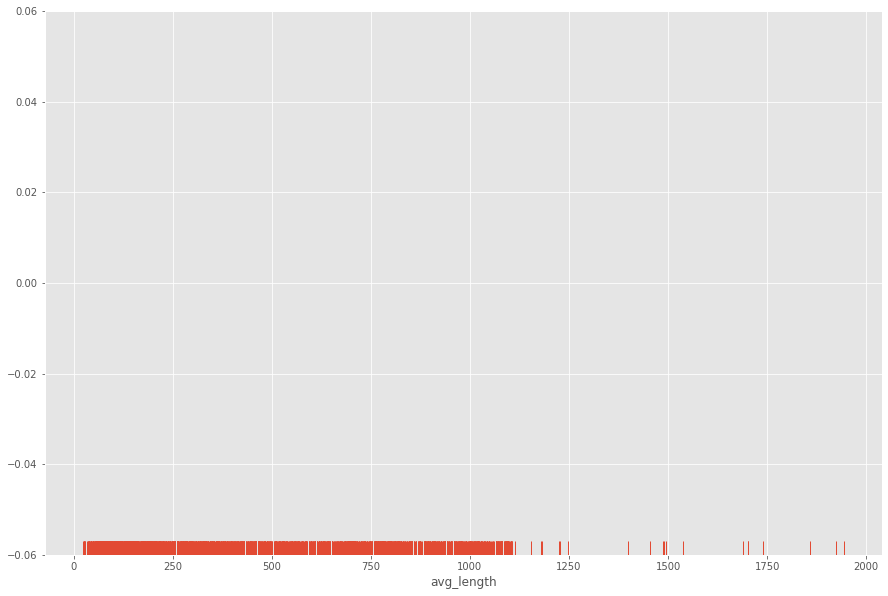

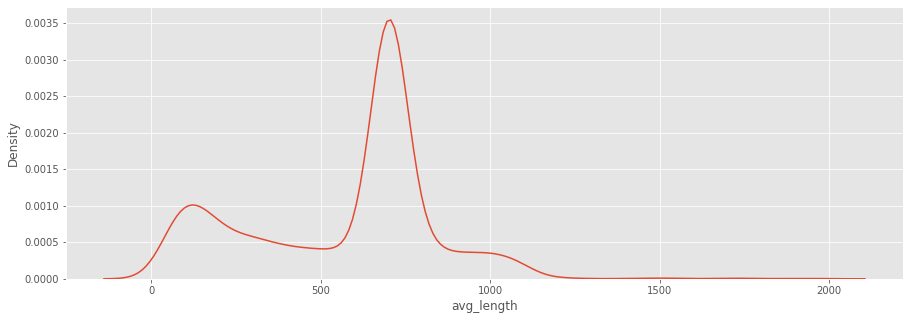

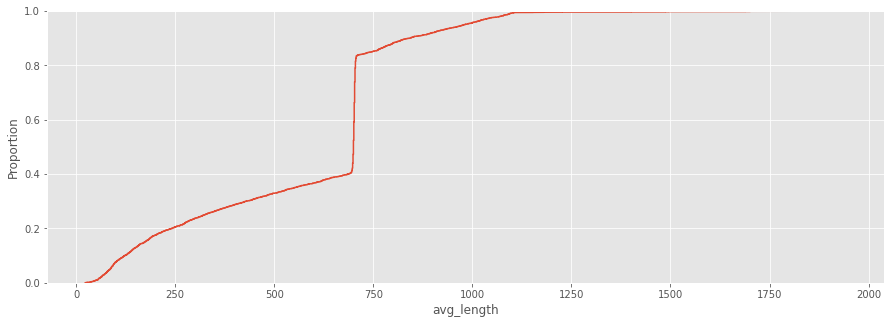

In [34]:
thanhniencongiao.plot()

### Observations

In [35]:
df = thanhniencongiao.df
limit = 400

In [36]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[-15])

31      CHA GIOAN B. TRẦN QUANG TRUYỀN XUẤT VIỆN\n\nCh...
36      #TNCG - SỐ CA COVID 19 LÂY NHIỄM CỘNG ĐỒNG TỪ ...
49      “Đừng tin những gì cộng sản nói, mà hãy xem nh...
52      "TÊN TÔI LÀ NẠN NHÂN CỘNG SẢN"\n\nĐó là câu tr...
68      30/4/1975 NGÀY CỐT NHỤC TƯƠNG TÀN, NGÀY NỀN VĂ...
                              ...                        
5465    Nguy cơ Thủ tướng Canada Justin Trudeau đang t...
5466    O la la, Việt Nam ta đây\nCó nơi nào trên thế ...
5467    Advancing human rights = chấm lửng (...)?\n\nA...
5477    Tân đại sứ quán Mỹ tại Việt Nam, ông Daniel Kr...
5509    BẰNG CHỨNG CỜ ĐỎ DIỄN MỸ ĐÁNH NGƯỜI\n\n#TNCG -...
Name: content, Length: 1029, dtype: object
--------------------



500 đồng không mua nổi cây kem, nhưng lại khiến cả một hệ thống dở khóc dở cười. Chỉ vì người dân dùng tiền lẻ mà lại dùng công an cơ động, cảnh sát để đánh đập và bắt bớ là cớ gì? Vũ khí của dân nay là tiền lẻ, Đừng giỡn mặt với dân!


In [37]:
limit = 1700

In [38]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

663     ĐÃ HƠN BA NĂM RỒI KHÔNG BIẾT TÍA RA SAO\n\nViế...
1213    QUẢ LÀ NGAO NGÁN CHO CÁC BẠN DU HỌC SINH\n\nCá...
2581    CHUNG TAY ĐÙM BỌC CÔ GÁI KIÊN CƯỜNG, BẤT KHUẤT...
2891    SĨ PHU VIỆT NAM SẼ BIỂU TÌNH NẾU NHÀ NƯỚC ĐỂ N...
3905    THÔNG BÁO KẺ GIẢ DANH LINH MỤC ĐỂ CHIA RẺ GIÁO...
3932    CÁN BỘ ĐẢNG BẢO KÊ CHO NGƯỜI DÂN CHIẾM ĐẤT CỦA...
Name: content, dtype: object
--------------------



ĐÃ HƠN BA NĂM RỒI KHÔNG BIẾT TÍA RA SAO

Viết vài dòng để nhớ đến tía ! Cầu mong tía mạnh khỏe bình an trong ngục tù tâm tối ấy.
Giờ không biết sức khỏe tía thế nào và sống ra sao khi mà không nhận được thức ăn từ gia đình và không được thăm nuôi như mọi người khác, thời gian tía ở cho đến nay đã hơn 3 năm rồi nhưng gia đình không được gặp mặt tía. Đã 2 năm con rất đau khổ và buồn nhưng cố gắng ôm chịu, nhưng điều con đáng buồn nhất mà không than với ai được, là hồ sơ của tía đi đến đâu cũng bị từ chối và lắc đầu từ tổ chức này đến tổ chức khác đều như nhau.
Không phải con đi tỵ nạn là sợ ở t

### Run Preprocessing method

In [39]:
# 400 - 10000
# ...
thanhniencongiao.preprocess()

Enter < limit:400
Enter > limit:10000


### Save

In [40]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	   viettan.csv
chantroimoi.pickle	 rfa.pickle		   viettan_fb.csv
giaochucchuvanan.pickle  sbtn.pickle		   viettan_fb.pickle
khoi8406.pickle		 thanhnienconggiao.pickle  viettan.pickle


In [41]:
thanhniencongiao.df.iloc[0]['content']

'“Nếu linh hồn thuộc về nhà nước, thì việc dâng linh hồn mình lên cho Thiên Chúa là một sự phản bội đối với nhà nước. Đó là lý do vì sao Giáo Hội Công Giáo bị dán nhãn là “Phản Động”. Một nhà nước vô thần hiểu rõ rằng họ không thể hoàn toàn sở hữu con người như một công cụ của nhà nước, trừ khi họ phá hủy Giáo Hội, mà Giáo Hội đó dạy rằng: Con người là con cái Thiên Chúa. Nhà nước đó không thể biến con người thành nô lệ cho tới khi nó nô lệ hóa được Giáo Hội, mà Giáo Hội đó dạy rằng: Con người có tự do”\n\nTrích: “Chủ nghĩa cộng sản và lương tâm Phương Tây” - Đức tổng Giám mục Fulton Sheen Hoa Kỳ.\n\nNguồn: Hoài Thạch Sơn.'

In [42]:
thanhniencongiao.save_preprocess(os.getcwd() + "/thanhnienconggiao")

In [43]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## SBTN

### Define new instances

In [44]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

sbtn = Dataframe('/1/' + 'sbtn.csv', 1)
print(sbtn.name)
sbtn.read_csv()

df = sbtn.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/sbtn.csv
df:        Unnamed: 0                                            content
0              0  Nghệ sỹ hài Dương Hoài Linh bị chỉ trích vì gi...
1              1  Người dân bị lập biên bản vì không muốn làm tr...
2              2  Ngân hàng thế giới nói dòng vốn đầu tư trực ti...
3              3  Người Việt uống nhiều bia rượu hơn trong đại d...
4              4  Nhiều người Việt Nam muốn đi Hoa Kỳ tiêm vacci...
...          ...                                                ...
2900        2900  Bộ công an đề nghị giảm tội cho Phạm Nhật Vũ v...
2901        2901  Đồng bằng sông Cửu Long đang chìm với tốc độ n...
2902        2902  CSVN đưa đơn vị trúng thầu xa lộ Bắc- Nam vào ...
2903        2903  Một thực tập sinh người Việt bị bắt ở Nhật tội...
2904        2904  Công an CSVN giải thích nguyên nhân trả 400 tộ...

[2905 rows x 2 columns]


,content,label,avg_length
0,Nghệ sỹ hài Dương Hoài Linh bị chỉ trích vì gi...,1,1683
1,Người dân bị lập biên bản vì không muốn làm tr...,1,1588
2,Ngân hàng thế giới nói dòng vốn đầu tư trực ti...,1,1412
3,Người Việt uống nhiều bia rượu hơn trong đại d...,1,1017
4,Nhiều người Việt Nam muốn đi Hoa Kỳ tiêm vacci...,1,1402
...,...,...,...
2900,Bộ công an đề nghị giảm tội cho Phạm Nhật Vũ v...,1,1734
2901,Đồng bằng sông Cửu Long đang chìm với tốc độ n...,1,1683
2902,CSVN đưa đơn vị trúng thầu xa lộ Bắc- Nam vào ...,1,1526
2903,Một thực tập sinh người Việt bị bắt ở Nhật tội...,1,1070


### Content Filter

In [45]:
temp = df[df['content'].str.contains("VN|CS|Việt Nam|chính phủ|công an|đánh|tù|dân chủ|cộng sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|nhà nước|tự do|dối|bê bối|lực lượng|quan chức|chính trị", regex = True, flags=re.IGNORECASE)]

print(sbtn.name)
sbtn.df = temp
sbtn.df

df = sbtn.df

/1/sbtn.csv


In [46]:
sbtn.df['content'].iloc[1]

'Người dân bị lập biên bản vì không muốn làm trái lương tâm, nhắm mắt bỏ phiếu cho ứng cử viên của đảng Cộng sản\nTin Vietnam.- Liên quan đến vở kịch bầu cử giả hiệu tại Việt Nam vào ngày 23 tháng 5 năm 2021, nhiều người dân phản ánh, họ đã bị các nhân viên, viên chức Cộng sản vác thùng phiếu đến tận nhà ép bỏ phiếu cho những ứng cử viên do đảng Cộng sản cử ra.\nTrên trang Facebook cá nhân, ông Đinh Văn Hải, ở huyện Đức Trọng, tỉnh Lâm Đồng cho biết, chiều tối 23, ban bầu cử địa phương đã mang theo thùng phiếu đến tận nhà ông để yêu cầu ông bỏ phiếu. Nhưng ông Hải đã kiên quyết từ chối vì ông không biết rõ các ứng cử viên là ai nên không thể làm trái lương tâm mình. Không thúc ép được ông Hải, ban bầu cử Cộng sản đã lập biên bản sự việc, xong rồi ra về.\nTrước đó, ông Hải giải thích, bầu cử là việc hệ trọng nên không biết thì không nên bầu. Ông Hải dẫn chứng, vào năm 2014, ông Nguyễn Sinh Hùng, lúc này là Chủ tịch Quốc hội Cộng sản đã tuyên bố trên báo chí rằng, Quốc hội tức là dân, dâ

In [47]:
aaa = pd.concat([temp, df])
aaa.drop_duplicates('content', keep = False)['content'].iloc[3]

IndexError: ignored

### Plot distribution

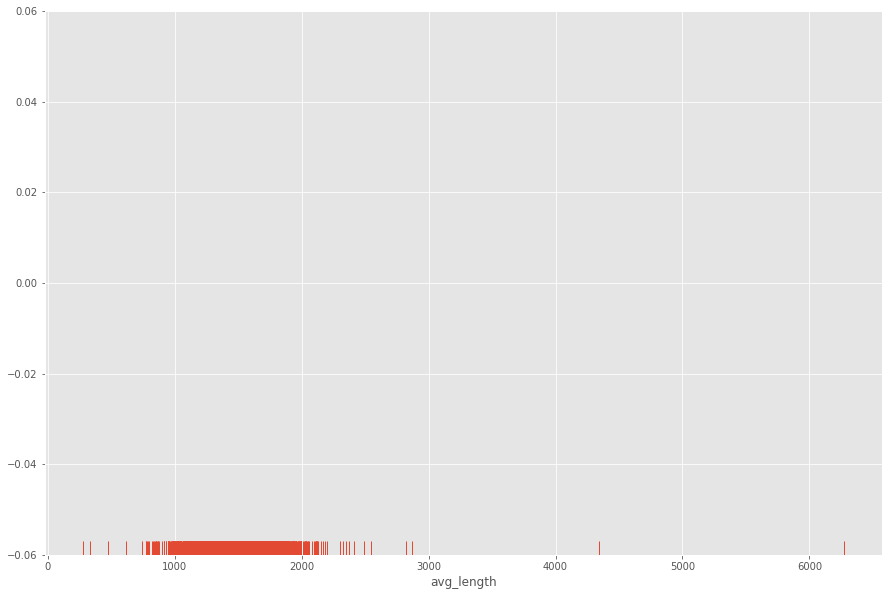

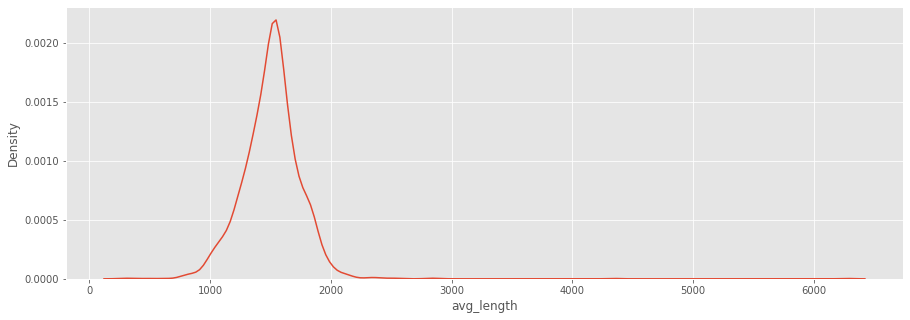

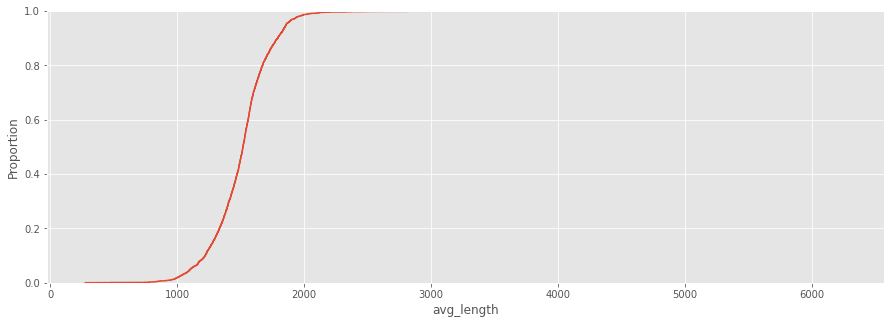

In [49]:
sbtn.plot()

### Observations

In [50]:
df = sbtn.df
limit = 700

In [51]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

332     Cuộc sống tuổi “xế chiều” của thành viên trong...
518     Thương phế binh VNCH nghĩ gì về cờ VNCH trong ...
913     Ngoại trưởng Pompeo gặp bộ trưởng công an CSVN...
2053    21 thuyền viên Việt Nam ở vùng biển Thái Lan đ...
Name: content, dtype: object
--------------------



Cuộc sống tuổi “xế chiều” của thành viên trong ban nhạc Phượng Hoàng
Trước năm 1975, trong giới thanh niên sinh viên, không ai lại không biết đến ban nhạc Phượng Hoàng. Sau khi cộng sản cưỡng chiếm miền Nam miền Nam, mỗi người lưu lạc một nơi. Kẻ trời Đông, người trời Tây, kẻ đã khuất. Xin mời quý khán giả theo dõi phóng sự sau đây:


In [52]:
limit = 4000

In [53]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

586     Tuyên bố của Hội Nhà Báo Độc Lập Việt Nam\nVề ...
2754    CSVN gia tăng căng thẳng với Trung Cộng trong ...
Name: content, dtype: object
--------------------



Tuyên bố của Hội Nhà Báo Độc Lập Việt Nam
Về việc: Nhà cầm quyền Việt Nam kết án thành viên Hội Nhà Báo Độc lập Việt Nam.
Ngày 05 tháng 01 năm 2021, Tòa án Tp Hồ Chí Minh đã tổ chức cái gọi là “Phiên tòa sơ thẩm” để xét xử ba thành viên của Hội Nhà Báo Độc Lập Việt Nam (HNBĐLVN) theo theo Điều 117 của Bộ luật Hình sự về cáo buộc “Làm, tàng trữ, phát tán hoặc tuyên truyền thông tin, tài liệu, vật phẩm nhằm chống Nhà nước Cộng hòa xã hội chủ nghĩa Việt Nam”.
Ba thành viên của Hội Nhà Báo Độc Lập Việt Nam bị nhà cầm quyền Việt Nam kết án với mức án như sau:
Tiến sĩ Phạm Chí Dũng, Chủ tịch Hội NBĐLVN, 15 năm tù, 3 năm quản chế.
Ông Nguyễn Tường Thụy, Phó Chủ tịch HNBĐLVN, 11 năm tù và 3 năm quản chế.
Ông Lê Hữu Minh Tuấn, Biên tập viên Vietnamthoibao.org, 11 năm tù và 3 năm quản chế.
Trước đó, nhà cầm quyền Việt Nam đã bắt 

### Run Preprocessing method

In [54]:
# 700 - 10000
# ...
sbtn.preprocess()

Enter < limit:700
Enter > limit:10000


### Save

In [55]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa.pickle		   viettan_fb.csv
chantroimoi.pickle	 sbtn.pickle		   viettan_fb.pickle
giaochucchuvanan.pickle  thanhnienconggiao.csv	   viettan.pickle
khoi8406.pickle		 thanhnienconggiao.pickle
phamminhvu.pickle	 viettan.csv


In [56]:
sbtn.df.iloc[1]['content']

'Người dân bị lập biên bản vì không muốn làm trái lương tâm, nhắm mắt bỏ phiếu cho ứng cử viên của đảng Cộng sản\nTin Vietnam.- Liên quan đến vở kịch bầu cử giả hiệu tại Việt Nam vào ngày 23 tháng 5 năm 2021, nhiều người dân phản ánh, họ đã bị các nhân viên, viên chức Cộng sản vác thùng phiếu đến tận nhà ép bỏ phiếu cho những ứng cử viên do đảng Cộng sản cử ra.\nTrên trang Facebook cá nhân, ông Đinh Văn Hải, ở huyện Đức Trọng, tỉnh Lâm Đồng cho biết, chiều tối 23, ban bầu cử địa phương đã mang theo thùng phiếu đến tận nhà ông để yêu cầu ông bỏ phiếu. Nhưng ông Hải đã kiên quyết từ chối vì ông không biết rõ các ứng cử viên là ai nên không thể làm trái lương tâm mình. Không thúc ép được ông Hải, ban bầu cử Cộng sản đã lập biên bản sự việc, xong rồi ra về.\nTrước đó, ông Hải giải thích, bầu cử là việc hệ trọng nên không biết thì không nên bầu. Ông Hải dẫn chứng, vào năm 2014, ông Nguyễn Sinh Hùng, lúc này là Chủ tịch Quốc hội Cộng sản đã tuyên bố trên báo chí rằng, Quốc hội tức là dân, dâ

In [57]:
sbtn.save_preprocess(os.getcwd() + "/sbtn")

In [58]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## RFA

### Define new instances

In [59]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

rfa = Dataframe('/1/' + 'rfa.csv', 1)
print(rfa.name)
rfa.read_csv()

df = rfa.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/rfa.csv
df:        Unnamed: 0                                            content
0              0  Tàu tuần duyên Mỹ khoác "áo mới": Vietnam Coas...
1              1  Hôm nay sau gần một tuần bị dân mạng phanh phu...
2              2  Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...
3              3  Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...
4              4  Công dân khiếm thị, vợ ứng viên độc lập, bị lậ...
...          ...                                                ...
1261        1261  Tổ chức Phóng viên Không Biên Giới (RSF) vào n...
1262        1262  Có vẻ như tỉnh Hải Dương - Việt Nam đang áp dụ...
1263        1263  Chiến dịch 5K: “Tứ trụ” không làm gương dù Bộ ...
1264        1264  Hải Dương: 60 người dùng 1 nhà vệ sinh trong k...
1265        1265  Mô hình chống dịch giá rẻ từng giúp VN thành c...

[1266 rows x 2 columns]


,content,label,avg_length
0,"Tàu tuần duyên Mỹ khoác ""áo mới"": Vietnam Coas...",1,1413
1,Hôm nay sau gần một tuần bị dân mạng phanh phu...,1,1758
2,Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...,1,580
3,Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...,1,690
4,"Công dân khiếm thị, vợ ứng viên độc lập, bị lậ...",1,813
...,...,...,...
1261,Tổ chức Phóng viên Không Biên Giới (RSF) vào n...,1,2214
1262,Có vẻ như tỉnh Hải Dương - Việt Nam đang áp dụ...,1,2159
1263,Chiến dịch 5K: “Tứ trụ” không làm gương dù Bộ ...,1,1413
1264,Hải Dương: 60 người dùng 1 nhà vệ sinh trong k...,1,1412


### Content Filter

In [60]:
temp = df[df['content'].str.contains("VN|CS|chính phủ|công an|đánh|tù|dân chủ|cộng sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|tự do|dối|bê bối|lực lượng|quan chức", regex = True, flags=re.IGNORECASE)]

print(rfa.name)
rfa.df = temp
rfa.df

# df = rfa.df

/1/rfa.csv


,content,label,avg_length
1,Hôm nay sau gần một tuần bị dân mạng phanh phu...,1,1758
2,Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...,1,580
3,Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...,1,690
4,"Công dân khiếm thị, vợ ứng viên độc lập, bị lậ...",1,813
5,"Thắng lợi bằng mọi giá\nNhiều ngày qua, Việt N...",1,2034
...,...,...,...
1260,Thủ tướng Việt Nam khẳng định nhập vaccine phò...,1,999
1261,Tổ chức Phóng viên Không Biên Giới (RSF) vào n...,1,2214
1262,Có vẻ như tỉnh Hải Dương - Việt Nam đang áp dụ...,1,2159
1263,Chiến dịch 5K: “Tứ trụ” không làm gương dù Bộ ...,1,1413


In [61]:
aaa = pd.concat([temp, df])
aaa.drop_duplicates('content', keep = False)['content']

0       Tàu tuần duyên Mỹ khoác "áo mới": Vietnam Coas...
6       Trung Quốc đe doạ Mỹ-Nam Hàn không can thiệp Đ...
8       Nghiên cứu sinh Viện Virus Vũ Hán nhập viện tr...
9       Để tìm hiểu thực tế, RFA hôm 24/5 liên lạc Anh...
21      Bóng tối của năng lượng mặt trời\nCác nhà máy ...
                              ...                        
1245    Bà cụ đọc thơ chống bành trướng Bắc Kinh\nĐoạn...
1251    Ấn Độ và TQ rút quân khỏi khu vực tranh chấp ở...
1252    Hàng loạt tỉnh thành cho học sinh nghỉ học sau...
1254    Hàng loạt tỉnh thành cho học sinh nghỉ học sau...
1264    Hải Dương: 60 người dùng 1 nhà vệ sinh trong k...
Name: content, Length: 390, dtype: object

### Plot distribution

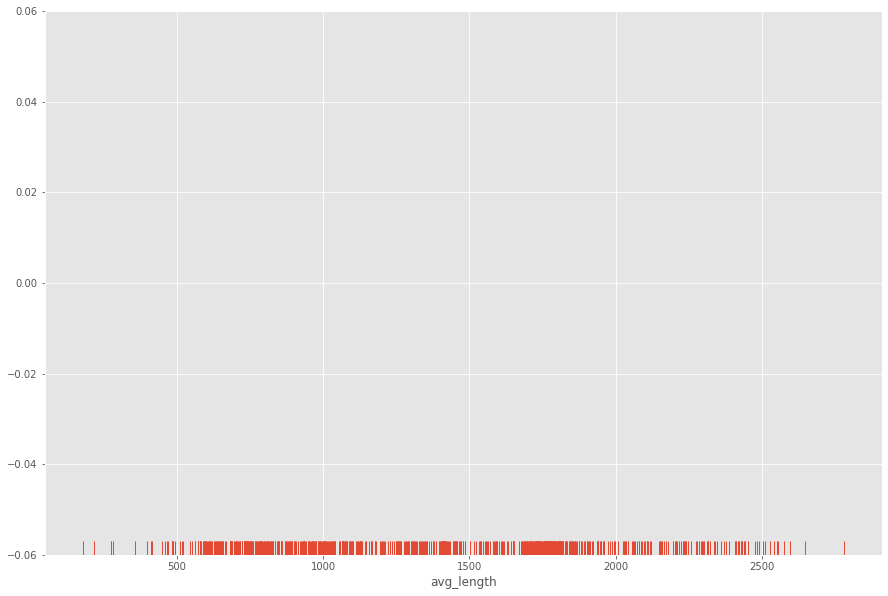

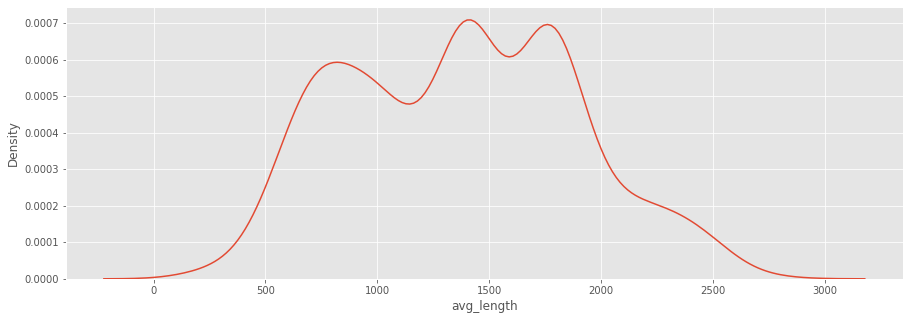

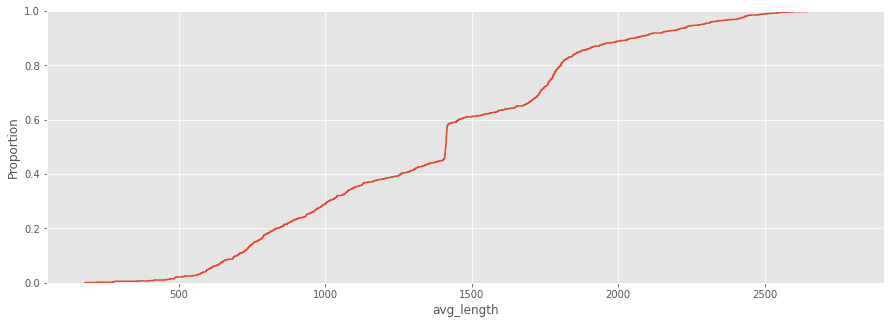

In [62]:
rfa.plot()

### Observations

In [63]:
df = rfa.df
limit = 700

In [64]:
df

,content,label,avg_length
1,Hôm nay sau gần một tuần bị dân mạng phanh phu...,1,1758
2,Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...,1,580
3,Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...,1,690
4,"Công dân khiếm thị, vợ ứng viên độc lập, bị lậ...",1,813
5,"Thắng lợi bằng mọi giá\nNhiều ngày qua, Việt N...",1,2034
...,...,...,...
1260,Thủ tướng Việt Nam khẳng định nhập vaccine phò...,1,999
1261,Tổ chức Phóng viên Không Biên Giới (RSF) vào n...,1,2214
1262,Có vẻ như tỉnh Hải Dương - Việt Nam đang áp dụ...,1,2159
1263,Chiến dịch 5K: “Tứ trụ” không làm gương dù Bộ ...,1,1413


In [65]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

2       Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...
3       Tổng bí thư Nguyễn Phú Trọng lê một chân đi bỏ...
16      Tổ bầu cử số 5 của phường Phù Đổng, thành phố ...
42      1. Thêm một ca tử vong do COVID-19 nâng tổng s...
43      1. Thêm một ca tử vong do COVID-19 nâng tổng s...
                              ...                        
1175    LHQ lên án các nước lấy cớ COVID-19 để đàn áp ...
1208    Tướng quân đội chuyển qua làm Trưởng ban Tuyên...
1250    Pháp: 10 ngàn người ký tên yêu cầu VN tôn trọn...
1258    RSF kêu gọi trả tự do cho nhà báo Phan Bùi Bảo...
1259    RSF kêu gọi trả tự do cho nhà báo Phan Bùi Bảo...
Name: content, Length: 89, dtype: object
--------------------





In [66]:
limit = 2500

In [67]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

24      Đại sứ Nga: "G7 mạo hiểm khi đẩy Nga-Trung gần...
265     Hãy trả tự do cho ba thành viên trong một nhà ...
392     Phó chủ tịch Bhargava nói Ủy hội cũng đang rất...
507     Giới quan sát cho rằng những hoài nghi và bức ...
619     Khủng hoảng thể chế luôn kéo theo suy giảm niề...
684     Xin có lời mừng, đồng thời cũng xin chia buồn ...
746     Hình ảnh Dương Khiết Trì “mồm phùng má trợn” n...
931     Nhà hoạt động dân chủ Đinh Quang Tuyến cũng từ...
1035    Không khác gì “cua gặp ếch”, ngoại trưởng Phạm...
1084    PGS-TS. Hoàng Dũng, thuộc trường Đại học Sư ph...
Name: content, dtype: object
--------------------



Đại sứ Nga: "G7 mạo hiểm khi đẩy Nga-Trung gần nhau"
Ông Andrei Kelin, Đại sứ Nga tại London, Anh, hôm 20/5 lên tiếng đe doạ các nước G7 (Mỹ, Anh, Đức Pháp, Nhật, Canada, Italy) rằng G7 đang khiến Nga và Trung Quốc xích lại gần với nhau.
Đại sứ Nga tại London: Đẩy Nga - Trung Quốc xích lại gần với nhau là "một trò mạo hiểm".

Đại sứ Nga: "G7 mạo hiểm khi đẩy Nga-Tr

### Run Preprocessing method

In [68]:
# 500 - 10000
# ...
rfa.preprocess()

Enter < limit:500
Enter > limit:10000


### Save

In [69]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa.pickle		   viettan.csv
chantroimoi.pickle	 sbtn.csv		   viettan_fb.csv
giaochucchuvanan.pickle  sbtn.pickle		   viettan_fb.pickle
khoi8406.pickle		 thanhnienconggiao.csv	   viettan.pickle
phamminhvu.pickle	 thanhnienconggiao.pickle


In [70]:
rfa.save_preprocess(os.getcwd() + "/rfa_fixed")

In [71]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## khoi8406

### Define new instances

In [72]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

khoi8406 = Dataframe('/1/' + 'khoi8406.csv', 1)
print(khoi8406.name)
khoi8406.read_csv()

df = khoi8406.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/khoi8406.csv
df:      Unnamed: 0                                            content
0            0                                                NaN
1            1                                                NaN
2            2  dân oan dương nội biểu tình trước đại sứ quán ...
3            3  Đánh đập dã man\n\nTrong những ngày qua, nhiều...
4            4  Có quý vị nào cho rằng biểu tình chống Trung Q...
5            5  LỜI KÊU GỌI BIỂU TÌNH CHỐNG TRUNG QUỐC XÂM LƯỢ...
6            6  Bên lề đường.....\n\nKhi mà cơm không đủ no, á...
7            7  Trả lời Xuân Hồng﻿ BBC. Bà Bảy Vân vợ Tổng BT ...
8            8  THẾ HỆ HÈN NHÁT\n\nChắc các chú, các anh sẽ bu...
9            9  CHỐNG TRUNG QUỐC KHÔNG PHẢI LÀ TỘI\n\n[BBC] Mẹ...
10          10  BÍ ẨN NHỮNG VỤ TỰ SÁT TẬP THỂ CỦA LOÀI VẬT\n\n...
11          11  CHÀO MỪNG KỶ NIỆM 50 NĂM NGÀY TRUYỀN THỐNG CSN...
12          12  Xuống đường nhằm giáo dục tinh thần yêu nước c...
13          13  Chị em ôi, Bắc Nam là một,\nChị em là r

,content,label,avg_length
2,dân oan dương nội biểu tình trước đại sứ quán ...,1,159
3,"Đánh đập dã man\n\nTrong những ngày qua, nhiều...",1,783
4,Có quý vị nào cho rằng biểu tình chống Trung Q...,1,656
5,LỜI KÊU GỌI BIỂU TÌNH CHỐNG TRUNG QUỐC XÂM LƯỢ...,1,1047
6,"Bên lề đường.....\n\nKhi mà cơm không đủ no, á...",1,698
7,Trả lời Xuân Hồng﻿ BBC. Bà Bảy Vân vợ Tổng BT ...,1,521
8,"THẾ HỆ HÈN NHÁT\n\nChắc các chú, các anh sẽ bu...",1,709
9,CHỐNG TRUNG QUỐC KHÔNG PHẢI LÀ TỘI\n\n[BBC] Mẹ...,1,981
10,BÍ ẨN NHỮNG VỤ TỰ SÁT TẬP THỂ CỦA LOÀI VẬT\n\n...,1,1441
11,CHÀO MỪNG KỶ NIỆM 50 NĂM NGÀY TRUYỀN THỐNG CSN...,1,776


### Content Filter

In [73]:
temp = df[df['content'].str.contains("VN|CS|Việt Nam|chính phủ|công an|đánh|tù|dân chủ|cộng sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|nhà nước|tự do|dối|bê bối|lực lượng|quan chức|chính trị", regex = True, flags=re.IGNORECASE)]

print(khoi8406.name)
khoi8406.df = temp
khoi8406.df

/1/khoi8406.csv


,content,label,avg_length
2,dân oan dương nội biểu tình trước đại sứ quán ...,1,159
3,"Đánh đập dã man\n\nTrong những ngày qua, nhiều...",1,783
4,Có quý vị nào cho rằng biểu tình chống Trung Q...,1,656
5,LỜI KÊU GỌI BIỂU TÌNH CHỐNG TRUNG QUỐC XÂM LƯỢ...,1,1047
6,"Bên lề đường.....\n\nKhi mà cơm không đủ no, á...",1,698
7,Trả lời Xuân Hồng﻿ BBC. Bà Bảy Vân vợ Tổng BT ...,1,521
9,CHỐNG TRUNG QUỐC KHÔNG PHẢI LÀ TỘI\n\n[BBC] Mẹ...,1,981
10,BÍ ẨN NHỮNG VỤ TỰ SÁT TẬP THỂ CỦA LOÀI VẬT\n\n...,1,1441
11,CHÀO MỪNG KỶ NIỆM 50 NĂM NGÀY TRUYỀN THỐNG CSN...,1,776
12,Xuống đường nhằm giáo dục tinh thần yêu nước c...,1,1476


In [74]:
khoi8406.df['content'].iloc[1]

'Đánh đập dã man\n\nTrong những ngày qua, nhiều tín đồ Phật Giáo Hòa Hảo chân tu ở Miền Tây tiếp tục bị đàn áp đáng ngại, nhất là trong những ngày lễ lớn của Đạo PGHH.\n\nCách nay ít lâu, một viên chức công an cao cấp tại Miền Tây khẳng định rằng:\n\n“Vấn đề tín ngưỡng tôn giáo là quyền của công dân VN được pháp luật VN bảo hộ. Không ai có quyền xâm phạm đến họ.”\n\nThì mới đây, vào thứ Hai 24 tháng 6 vừa rồi, tức ngay trước ngày18 tháng Năm âm lịch kỷ niệm thời điểm Đức Huỳnh Giáo Chủ khai sáng Đạo PGHH tại Miền Tây Nam Bộ cách nay hơn 50 năm, lực lượng gồm công an, mật vụ, dân phòng tấn công đoàn rước lễ tại Quang Minh Tự ở ấp Long Hoà 2, xã Long Điền A, huyện Chợ Mới, tỉnh An Giang. Tu sĩ Nguyễn Văn…\n\nYOUTUBE.COM\nCông An đàn áp PGHH - Tín đồ Phật Giáo Hòa Hảo liên tiếp bị đàn áp'

In [75]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[3])

Vụ án Tiên Lãng 2 - Phần 1: Đến đập nhà không cần giấy tờ !
Tái định cư… ngoài đường

PN - UBND quận Thủ Đức ra quyết định (QĐ) yêu cầu người dân tự tháo dỡ nhà trong vòng 20 ngày để phục vụ dự án đường Tân Sơn Nhất - Bình Lợi - Vành Đai Ngoài (TSN - BL - VĐN), nếu không sẽ cưỡng chế. Thế nhưng quận lại chưa bố trí nhà tái định cư và cũng không có phương án tạm cư cho người dân.

Đất tái định cư để làm gì?

Được biết, dự án TSN - BL - VĐN được UBND TP.HCM ra QĐ số 19/QĐ-UBND thu hồi đất vào đầu năm 2008. Giá bồi thường cho người dân bị thu hồi đất trên tuyến đường Kha Vạn Cân (Q.Thủ Đức) là 10,7 triệu đồng/m2. Phần lớn các hộ dân đều đồng tình với phương án đền bù này, nhưng riêng 36 hộ dân ở…

YOUTUBE.COM
Tái định cư... ngoài đường - Dân thuộc dự án đường Tân Sơn Nhất


### Plot distribution

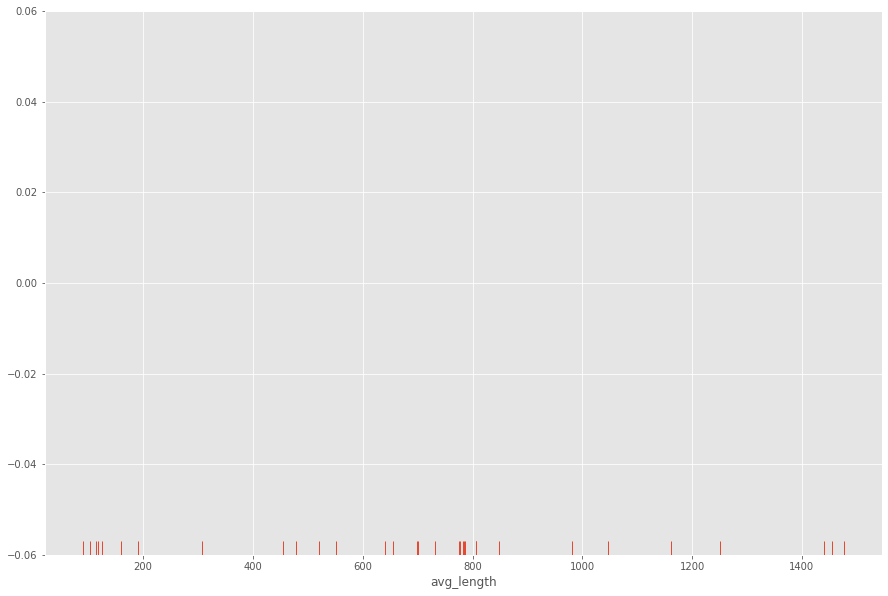

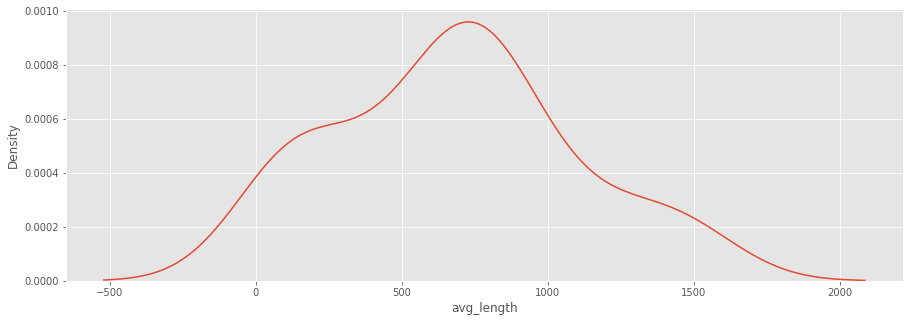

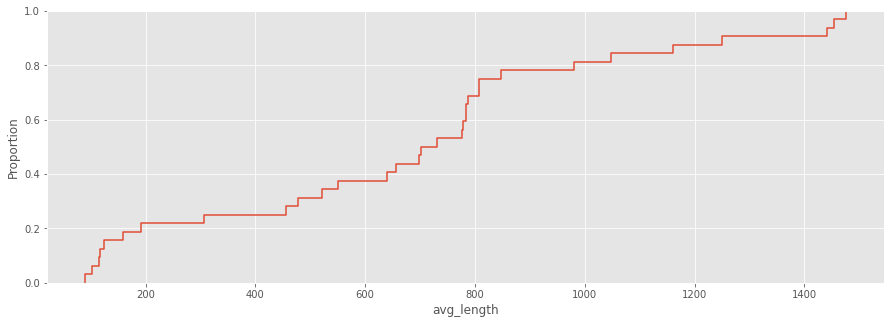

In [76]:
khoi8406.plot()

### Observations

In [77]:
df = khoi8406.df
limit = 500

In [78]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[3])

2     dân oan dương nội biểu tình trước đại sứ quán ...
23    HỘI NHỮNG NGƯỜI GHÉT BỌN PHẢN ĐỘNG\n\nYOUTUBE....
24    Hàng triệu người đã bỏ mạng trong thảm họa thu...
27    MẶT TRẬN THANH NIÊN CHỐNG PHẢN ĐỘNG !Đại Học B...
36    “Đừng tự hào vì nước Việt Nam nghèo nhưng có l...
37    GDATA.YOUTUBE.COM\nNhat Ky Yeu Nuoc - Tình Hìn...
39    Bất HủNhững Câu Nói Bất HủTôi vẫn vào được FB ...
40    DANLAMBAO1.WORDPRESS.COM\nKhối 8406: Tuyên bố ...
42    Triệu Người Việt Yêu Nước Xuống Đường Đòi Tự D...
45    Khối 8406 là một tập hợp những Công dân Việt N...
Name: content, dtype: object
--------------------



MẶT TRẬN THANH NIÊN CHỐNG PHẢN ĐỘNG !Đại Học Bách Khoa Hà NộiHỘI NHỮNG NGƯỜI GHÉT BỌN PHẢN ĐỘNG

Nhật ký yêu nước is with Joe Cao and 24 others.
18 April 2011 at 16:57 ·

Mời các bạn cho ý kiến xem tại sao, trên trang web của TRUNG TÂM DỰ BÁO KHÍ TƯỢNG THỦY VĂN TRUNG ƯƠNG, quần đảo Hoàng Sa và Trường Sa lại có màu nhạt giống màu các vùng đất không phải của là lãnh thổ của Việt Nam.

h

In [79]:
limit = 1000

In [80]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

5     LỜI KÊU GỌI BIỂU TÌNH CHỐNG TRUNG QUỐC XÂM LƯỢ...
10    BÍ ẨN NHỮNG VỤ TỰ SÁT TẬP THỂ CỦA LOÀI VẬT\n\n...
12    Xuống đường nhằm giáo dục tinh thần yêu nước c...
16    Vụ Bản, Nam Định: cướp đất, đánh dân tàn bạo\n...
20    Một tuyên bố chung dài 3208 chữ có thể được tó...
26    MẶT TRẬN THANH NIÊN CHỐNG PHẢN ĐỘNG !HỘI NHỮNG...
Name: content, dtype: object
--------------------



LỜI KÊU GỌI BIỂU TÌNH CHỐNG TRUNG QUỐC XÂM LƯỢC NGÀY 9/12/2012

Địa điểm tập kết: trước cửa Nhà Hát Lớn - Hà Nội. Bắt đầu lúc 9h.
Tuần hành đến Đại Sứ quán Trung Quốc - số 46 đường Hoàng Diệu.

VIDEO VỚI LỜI KÊU GỌI:
http://www.youtube.com/watch?v=diMtYQlVSsw

Nhật ký yêu nước is with Nguyễn Hoàng Vi and 34 others.
5 December 2012 at 12:52 ·

♥♥♥♥♥♥ Sài Gòn và Hà Nội cùng đứng lên ♥♥♥♥♥♥

LỜI KÊU GỌI BIỂU TÌNH CHỐNG TRUNG QUỐC XÂM LƯỢC NGÀY 9/12/2012

Địa điểm tập kết: trước cửa Nhà Hát Lớn - Hà Nội. Bắt đầu lúc 9h.
Tuần hành đến Đại Sứ quán Trung Quốc - số 46 đường Hoàng Diệu.

♥ Đề nghị đồng bào chia s

### Run Preprocessing method

In [81]:
# 500 - 1000
# ...
khoi8406.preprocess()

Enter < limit:500
Enter > limit:1000


### Save

In [82]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa_fixed.csv		thanhnienconggiao.pickle
chantroimoi.pickle	 rfa.pickle		viettan.csv
giaochucchuvanan.pickle  sbtn.csv		viettan_fb.csv
khoi8406.pickle		 sbtn.pickle		viettan_fb.pickle
phamminhvu.pickle	 thanhnienconggiao.csv	viettan.pickle


In [83]:
khoi8406.df.iloc[1]['content']

'Có quý vị nào cho rằng biểu tình chống Trung Quốc "không hề có tác dụng gì" thì hãy nên xem lại rằng: liệu phát biểu phản đối Trung Quốc như nhai đi nhai lại của Lương Thanh Nghị có được trích dẫn, đăng tải nhiều bằng hình ảnh của cuộc biểu tình chống Trung Quốc vừa qua không?\n\nThống kê có thấy đã có ít nhất 10 hãng thông tấn lớn nhất thế giới như AP, AFP, BBC, VOA, Al Jazeera, Euronews, Fox News, Yahoo!News, Washington Post, ABC, Guardian, DW đã đăng tải thông tin về cuộc biểu tình ngày 09/12 (chưa kể các tờ báo nhỏ đăng lại).\n\nCuộc biểu tình đã đạt được mục đích quan trọng là đánh động dư luận thế giới về những gì Trung Quốc đang làm ở Biển Đông.'

In [84]:
khoi8406.save_preprocess(os.getcwd() + "/khoi8406")

In [85]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## chantroimoi media

### Define new instances

In [86]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [87]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

chantroimoi = Dataframe('/1/' + 'chantroimoi_media.csv', 1)
print(chantroimoi.name)
chantroimoi.read_csv()

df = chantroimoi.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/chantroimoi_media.csv
df:        Unnamed: 0                                            content
0              0  EM CHỈ MONG “MỌI VIỆC SẼ ỔN” THÔI MÀ ?\n\nVu K...
1              1  NHÀ CHO CÔNG NHÂN QUÁ ÍT!\n\nPhạm Nhật Bình - ...
2              2  Vài trao đổi cùng “bác cả” Trọng... về "kinh t...
3              3  BẦU CỬ KIỂU Ở VN XÃ NGHĨA\n\nNguyễn Doãn Đôn\n...
4              4  Nguyễn Phú Trọng và con đường tiến lên xã hội ...
...          ...                                                ...
3917        3917  Trần Thị Kim Anh\n·\nVà tại sao các đảng viên ...
3918        3918  Ngăn chặn kẻ ức hiếp ở Biển Đông\n\nGregory B....
3919        3919  Rập khuôn Trung Quốc, Sài Gòn lắp thêm 10.000 ...
3920        3920  Lo cho đảng viên trẻ bị diễn biến hoà bình\n\n...
3921        3921  Trung Hoa Mộng\n\nNgô Nhật Đăng\n\nCác nhà phâ...

[3922 rows x 2 columns]


,content,label,avg_length
0,EM CHỈ MONG “MỌI VIỆC SẼ ỔN” THÔI MÀ ?\n\nVu K...,1,704
1,NHÀ CHO CÔNG NHÂN QUÁ ÍT!\n\nPhạm Nhật Bình - ...,1,704
2,"Vài trao đổi cùng “bác cả” Trọng... về ""kinh t...",1,818
3,BẦU CỬ KIỂU Ở VN XÃ NGHĨA\n\nNguyễn Doãn Đôn\n...,1,704
4,Nguyễn Phú Trọng và con đường tiến lên xã hội ...,1,697
...,...,...,...
3917,Trần Thị Kim Anh\n·\nVà tại sao các đảng viên ...,1,119
3918,Ngăn chặn kẻ ức hiếp ở Biển Đông\n\nGregory B....,1,708
3919,"Rập khuôn Trung Quốc, Sài Gòn lắp thêm 10.000 ...",1,703
3920,Lo cho đảng viên trẻ bị diễn biến hoà bình\n\n...,1,703


### Content Filter

In [88]:
temp = df[df['content'].str.contains("VN|CS|Việt Nam|chính phủ|công an|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|nhà nước|tự do|dối|thất bại|bê bối|lực lượng|quan chức|chính trị|tầm phào|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(chantroimoi.name)
chantroimoi.df = temp
chantroimoi.df

/1/chantroimoi_media.csv


,content,label,avg_length
1,NHÀ CHO CÔNG NHÂN QUÁ ÍT!\n\nPhạm Nhật Bình - ...,1,704
2,"Vài trao đổi cùng “bác cả” Trọng... về ""kinh t...",1,818
3,BẦU CỬ KIỂU Ở VN XÃ NGHĨA\n\nNguyễn Doãn Đôn\n...,1,704
4,Nguyễn Phú Trọng và con đường tiến lên xã hội ...,1,697
5,BẦU\n\nNguyễn Thông\n\nCứ như tivi báo chí tru...,1,678
...,...,...,...
3917,Trần Thị Kim Anh\n·\nVà tại sao các đảng viên ...,1,119
3918,Ngăn chặn kẻ ức hiếp ở Biển Đông\n\nGregory B....,1,708
3919,"Rập khuôn Trung Quốc, Sài Gòn lắp thêm 10.000 ...",1,703
3920,Lo cho đảng viên trẻ bị diễn biến hoà bình\n\n...,1,703


In [89]:
print(chantroimoi.df['content'].iloc[10])

‘Tào lao Việt Nam’: Câu chuyện nhiều tập‘Tào lao Việt Nam’: Câu chuyện nhiều tập

Hoàng Trường (Gởi VOA từ Sài Gòn)

Từ tuyên bố của Chủ tịch nước, Tổng bí thư đến các phát biểu của Thủ tướng, kèm theo đó là những chủ trương trái khoáy… con dân nước Việt hàng ngày hàng giờ phải chứng kiến biết bao điều tầm phào và sáo rỗng.

Tuyên bố của Nguyễn Xuân Phúc

Ông Nguyễn Xuân Phúc có lẽ là nguyên thủ hiếm hoi trong lịch sử nước nhà, vì đã để lại những phát ngôn “có cánh”. Từ cách gọi tắt 4 nước ASEAN là “cờ-lờ-mờ-vờ” hồi đứng đầu cái nội các của “hậu Ba A-Tí” (Y-Tá Nguyễn Tấn Dũng) cho đến tuyên bố mới đây nhất về một nền “dân chủ tào lao” nào đó. Trong tuyên bố ngắn ngủn “Đảng luôn xem trọng ý kiến…


In [90]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[-10])

Vì cậu là ... hàng thật!

Thach Vu

Cậu chỉ mới 21 tuổi ...

Cậu không biết 29 ngoại ngữ ...

Cậu không biết cách nung gạch sưởi mùa đông ...

Cậu không biết làm thơ hay mượn thơ trong tù ...

Cậu không có bút hiệu nào khác để viết về Hoàng Chi Phong ...

Cậu không che giấu dáng vẻ "mặt dơi mõm chuột" của mình ...

Thế mà cả thế giới nể phục, yêu quí cậu.

Vì họ biết cậu là ... hàng thật!


### Plot distribution

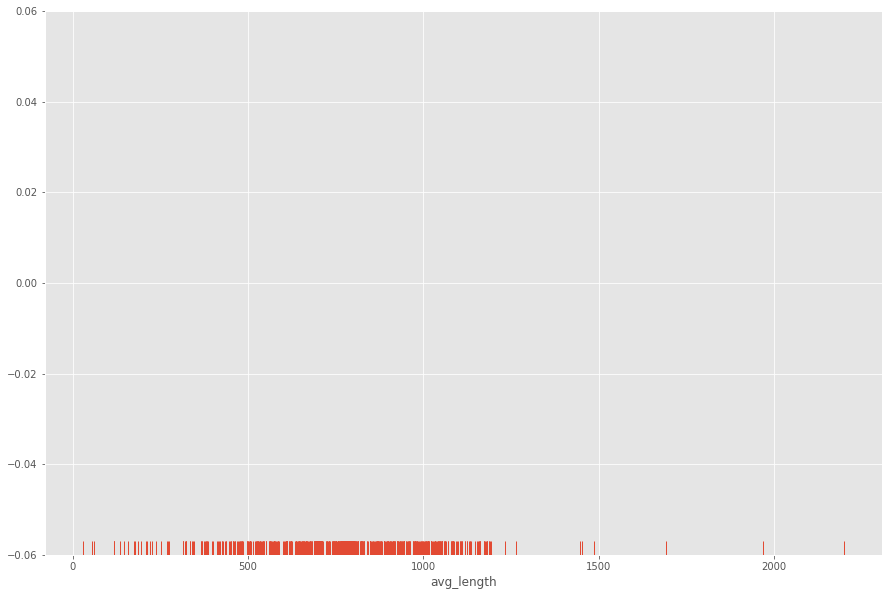

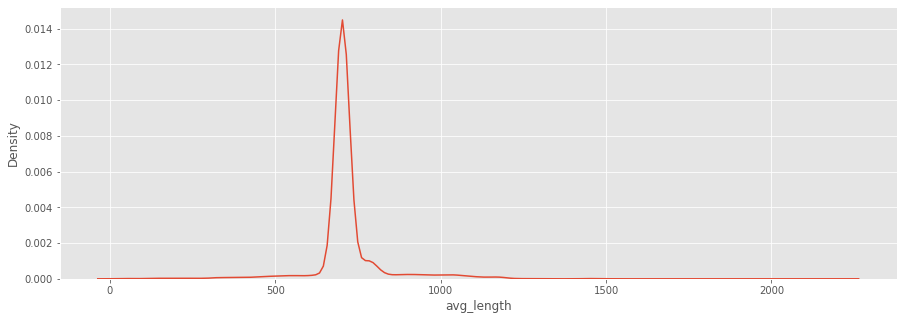

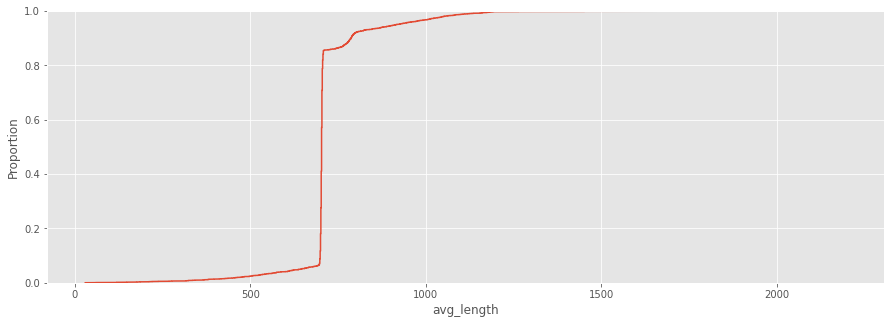

In [91]:
chantroimoi.plot()

### Observations

In [92]:
df = chantroimoi.df
limit = 450

In [93]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[4])

80      Chuyện rác ở Việt Nam: Quan chức ăn rác, nhân ...
144     Tuyên Cáo của Cộng Đồng Người Việt Tự Do Liên ...
250     Nếu sau năm 1975, thay vì đánh tư sản, người t...
341     Kiến thức cần chia sẻ gấp:\n\nĐể công an, an n...
567     Bà Aung San Suu Kyi, khôi nguyên giải Nobel Hò...
674     Ad hỏi thật các bạn dư luận viên, ak47, công a...
783     BIẾN CỐ ĐỒNG TÂM: NHỮNG SỰ THẬT CẦN TOÀN DÂN N...
1028    Hãy xem hình\n\nhttps://www.facebook.com/photo...
1124    Ông nào so sánh thế này là chẳng hiểu gì về đi...
1127    Chân Trời Mới Media kính chúc Quý Vị và Gia Đì...
1167    Chỉ 5 triệu người yêu cộng sản chuyên chính, Đ...
1202    Tù nhân lương tâm Trần Huỳnh Duy Thức ngừng tu...
1219    Các phân tích gia chính trị: những mối quan tâ...
1250    Bánh vẽ của đảng CSVN dành cho nhân dân\nHình:...
1388    Ô. Lý Thái Hùng giải thích vì sao tứ trụ Trọng...
1500    Đã sang ngày thứ 48!\n\nTỰ DO CHO TRẦN HUỲNH D...
1504    Việt Nam có luật pháp không? Nếu có thì tại sa...
1547    Phan Đ

In [94]:
limit = 1500

In [95]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

212    30.4: NGHĨ VỀ PHẨM CHẤT ANH HÙNG CỦA NGÀNH GIÁ...
484    GIA ĐÌNH CÔNG DÂN ÚC CHÂU VĂN KHẢM LO SỢ CHO A...
735    CÓ PHẢI MỘT “MÙA XUÂN ĐÔNG Á” ĐANG DIỄN RA?\n\...
Name: content, dtype: object
--------------------



30.4: NGHĨ VỀ PHẨM CHẤT ANH HÙNG CỦA NGÀNH GIÁO

Chu Mộng Long

Tháng trước, khi tôi đóng cửa FB để luyện công thì nghe ầm ĩ trong giới giang hồ về một sự kiện trọng đại ở Trường Tiểu học Sài Sơn B, Quốc Oai, Hà Nội. Học sinh lớp 5 mà dám tấn công cô giáo ngay tại lớp học là chuyện xưa nay chưa từng có. Thường học sinh tiểu học sợ cô giáo hơn sợ cọp. Ai không tin thì thử xem. Một đứa bé hư hỏng, lì lợm nhất người lớn nói không nghe, chỉ cần bắt máy doạ gọi cho cô giáo là nó hết hồn.

Vậy thì chỉ có thể cô giáo Tuất thuộc thế lực thù địch, phản động, chống phá sự nghiệp của nhà trường mới có chuyện học sinh bé con đồng loạt tấn công cô giáo. Đúng là tuổi nhỏ chí lớn. Điều này tôi chỉ thấy trong…

Lich Tran is feeling chill at Trường THCS Hiến Nam.
April 29 at 3:59 PM

### Run Preprocessing method

In [96]:
# 450 - 1500
# ...
chantroimoi.preprocess()

Enter < limit:450
Enter > limit:1500


### Save

In [97]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa_fixed.csv		   viettan.csv
chantroimoi.pickle	 rfa.pickle		   viettan_fb.csv
giaochucchuvanan.pickle  sbtn.csv		   viettan_fb.pickle
khoi8406.csv		 sbtn.pickle		   viettan.pickle
khoi8406.pickle		 thanhnienconggiao.csv
phamminhvu.pickle	 thanhnienconggiao.pickle


In [98]:
chantroimoi.df.iloc[1]['content']

'Vài trao đổi cùng “bác cả” Trọng... về "kinh tế thị trường định hướng XHCN"\n\nBài viết với nhan đề ‘Một số vấn đề lý luận và thực tiễn về chủ nghĩa xã hội và con đường đi lên chủ nghĩa xã hội ở Việt Nam’ của Tổng Bí thư Đảng cộng sản Việt Nam Nguyễn Phú Trọng đã bị nhiều ý kiến phản bác.\nTác già Lưu trọng Văn đặc biệt chú ý đến phần ông Trọng nói về kinh tế thị trường định hướng XHCN.\n\nBài \'Vài trao đổi cùng “bác cả” Trọng\' - Lưu Trọng Văn\n\n#ViệtTân #NguyễnPhúTrọng\n\nNếu không xem được trên YouTube, bạn có thể vào link này để xem: \nDO YOUTUBE BỊ NHÀ CẦM QUYỀN CSVN ÁP LỰC NGĂN CHẶN MỘT CÁCH BẤT HỢP PHÁP KHÔNG CHO NHIỀU VIDEO CỦA VIỆT TÂN ĐƯỢC XEM Ở VIỆT NAM\n\nVIMEO.COM\nVài trao đổi cùng “bác cả” Trọng về "kinh tế thị trường định hướng XHCN"'

In [99]:
chantroimoi.save_preprocess(os.getcwd() + "/chantroimoi")

In [100]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## BPSOS

### Define new instances

In [101]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [102]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

bpsos = Dataframe('/1/' + 'bpsos.csv', 1)
print(bpsos.name)
bpsos.read_csv()

df = bpsos.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/bpsos.csv
df:        Unnamed: 0                                            content
0              0  Theo các đại diện của cư dân Tiểu Khu 179, chí...
1              1  Trong cuộc bầu cử ngày 23 tháng 5 năm 2021 vừa...
2              2  MỘT CUỘC BIỂU TÌNH ĐƯỢC COI LÀ HỢP PHÁP TẠI VI...
3              3  \n\nBPSOS - Vietnam Advocacy Project\n20 mei o...
4              4  Gần đây, nhiều cá nhân, tổ chức bảo vệ nhân qu...
...          ...                                                ...
1384        1384  https://news.zing.vn/bi-cong-an-phuong-moi-len...
1385        1385  Trong thời gian qua, thành viên Hội Cờ Đỏ đã c...
1386        1386  Trong một vụ kiện dân sự, toà án đòi hỏi nguyê...
1387        1387  http://www.tinmungchonguoingheo.com/blog/2018/...
1388        1388  Dưới đây là hướng dẫn về cách ứng xử khi nhận ...

[1389 rows x 2 columns]


,content,label,avg_length
0,"Theo các đại diện của cư dân Tiểu Khu 179, chí...",1,3085
1,Trong cuộc bầu cử ngày 23 tháng 5 năm 2021 vừa...,1,1882
2,MỘT CUỘC BIỂU TÌNH ĐƯỢC COI LÀ HỢP PHÁP TẠI VI...,1,1406
3,\n\nBPSOS - Vietnam Advocacy Project\n20 mei o...,1,2297
4,"Gần đây, nhiều cá nhân, tổ chức bảo vệ nhân qu...",1,1606
...,...,...,...
1384,https://news.zing.vn/bi-cong-an-phuong-moi-len...,1,528
1385,"Trong thời gian qua, thành viên Hội Cờ Đỏ đã c...",1,1425
1386,"Trong một vụ kiện dân sự, toà án đòi hỏi nguyê...",1,1425
1387,http://www.tinmungchonguoingheo.com/blog/2018/...,1,457


### Content Filter

In [103]:
temp = df[df['content'].str.contains("VN|CS|Việt Nam|chính phủ|công an|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|" + 
        "chủ tịch|cướp|trung ương|lãnh đạo|nhà nước|tự do|dối|thất bại|bê bối|lực lượng|quan chức|chính trị|tầm phào|chính quyền|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(bpsos.name)
bpsos.df = temp
bpsos.df

/1/bpsos.csv


,content,label,avg_length
0,"Theo các đại diện của cư dân Tiểu Khu 179, chí...",1,3085
1,Trong cuộc bầu cử ngày 23 tháng 5 năm 2021 vừa...,1,1882
2,MỘT CUỘC BIỂU TÌNH ĐƯỢC COI LÀ HỢP PHÁP TẠI VI...,1,1406
3,\n\nBPSOS - Vietnam Advocacy Project\n20 mei o...,1,2297
4,"Gần đây, nhiều cá nhân, tổ chức bảo vệ nhân qu...",1,1606
...,...,...,...
1381,\n\nVõ An Đôn\n22 oktober 2018 om 09:29 ·\nHÒA...,1,2252
1384,https://news.zing.vn/bi-cong-an-phuong-moi-len...,1,528
1385,"Trong thời gian qua, thành viên Hội Cờ Đỏ đã c...",1,1425
1387,http://www.tinmungchonguoingheo.com/blog/2018/...,1,457


In [104]:
for post in bpsos.df['content'].iloc[:30]:
    print(post)
    print("---------------------")
# print(bpsos.df['content'].iloc[:-1])

Theo các đại diện của cư dân Tiểu Khu 179, chính quyền huyện sẽ cấp thẻ căn cước công dân vào tháng 7 này, và cũng tháng 7 này sẽ triển khai các dự án xây dựng hạ tầng cơ sở bao gồm đường xá, trạm xá y tế, nhà… Meer trẻ, sân chơi, và trung tâm cộng đồng. Đầu tháng 3 vừa qua, Quân Khu 7 cử 2 giáo viên bình dân học vụ để dạy đọc và viết cho các người Hmong chưa từng đến trường. Hiện có trên 40 học viên theo học.

Theo các đại diện của cư dân Tiểu Khu 179, chính quyền huyện sẽ cấp thẻ căn cước công dân vào tháng 7 này, và cũng tháng 7 này sẽ triển khai các dự án xây dựng hạ tầng cơ sở bao gồm đường xá, trạm xá y tế, nhàMeer trẻ, sân chơi, và trung tâm cộng đồng. Đầu tháng 3 vừa qua, Quân Khu 7 cử 2 giáo viên bình dân học vụ để dạy đọc và viết cho các người Hmong chưa từng đến trường. Hiện có trên 40 học viên theo học.

BPSOS - Vietnam Advocacy Project
6 uur ·
Khẳng định tư cách cử tri, nhiều trăm tín đồ Tin Lành Hmong đi bầu lần đầu sau hơn 21 năm
• Một bước tiến nhằm xoá bỏ tình trạng kh

In [105]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'])

12           \n\nDVOV.ORG\ndvov.org\n\nDVOV.ORG\ndvov.org
25      Người Mỹ gốc Việt trước nạn kỳ thị dân Á Châu\...
38      QUYỀN CỦA NGƯỜI BỊ THIỆT HẠI DO TAI NẠN GIAO T...
42      NƠI CƯ TRÚ CỦA NHÀ TU HÀNH THEO LUẬT CƯ TRÚ MỚ...
48      SAU NGÀY 1 THÁNG 7 NĂM 2021 SẼ KHÔNG CẦN ĐẾN S...
                              ...                        
1375    Lus Hmoob, the first in a series of three vide...
1376    \n\nĐôn An Võ is met Võ An Đôn en THÍCH THIỆN ...
1379    This video, the first in a series of three vid...
1382    This video in Vietnamese language describes ho...
1386    Trong một vụ kiện dân sự, toà án đòi hỏi nguyê...
Name: content, Length: 249, dtype: object


### Plot distribution

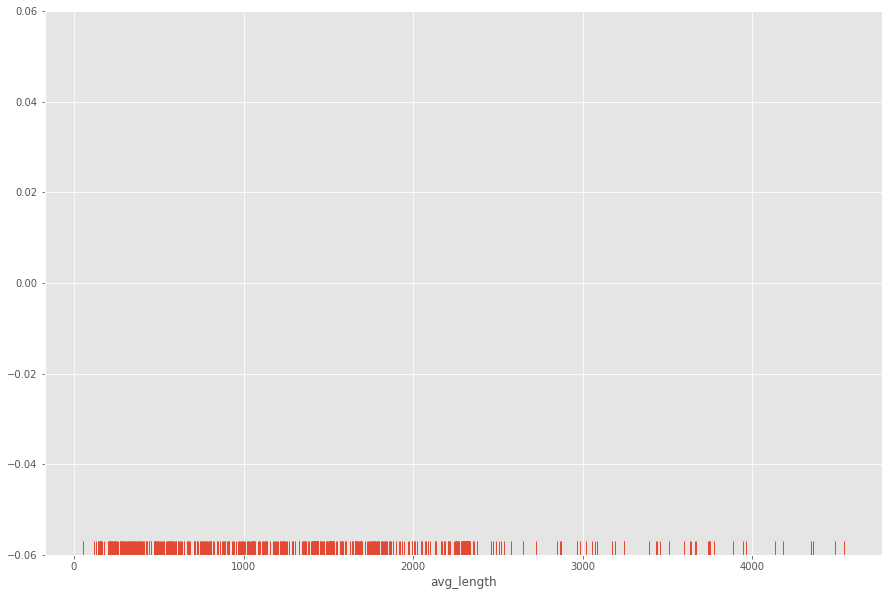

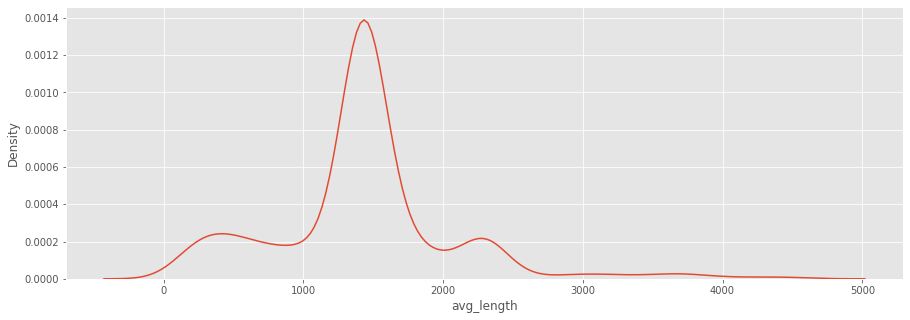

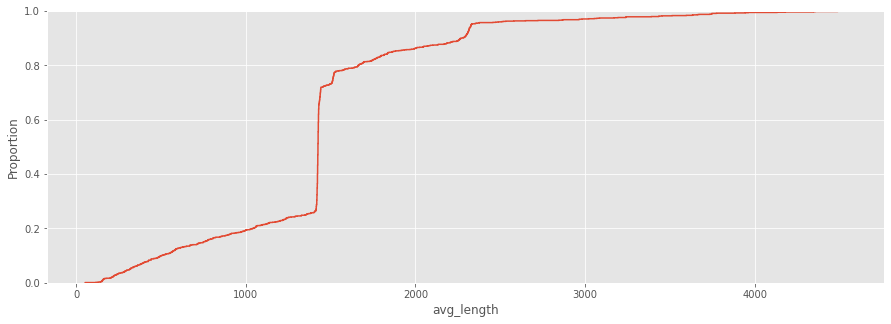

In [106]:
bpsos.plot()

### Observations

In [107]:
df = bpsos.df
limit = 1000

In [108]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

6       TAND tỉnh Khánh Hòa đã đưa ra xét xử sơ thẩm v...
28      Luật bảo vệ bí mật nhà nước\nSau Video “Quyết ...
55      Những điểm cần lưu ý trong Nghị định 162/2017/...
67      TS Nguyễn Đình Thắng phát biểu tại Hội Đồng Nh...
84      \n\nBPSOS - Đề Án Dân Quyền Việt Nam heeft het...
                              ...                        
1372    https://tuoitre.vn/lam-gi-khi-cong-an-trieu-ta...
1374    Đây là video thứ 2 về tình trạng “vô tổ quốc” ...
1377    https://www.vncrp.org/hmong-statelessness-proj...
1384    https://news.zing.vn/bi-cong-an-phuong-moi-len...
1387    http://www.tinmungchonguoingheo.com/blog/2018/...
Name: content, Length: 218, dtype: object
--------------------





In [109]:
for post in df[df['avg_length'] < limit ]['content']:
    print(post)
    print('-----------------------')

TAND tỉnh Khánh Hòa đã đưa ra xét xử sơ thẩm vụ án ông Nguyễn Văn Bình (ngụ tại TP Nha Trang) khởi kiện Chủ tịch UBND tỉnh Khánh Hòa về việc từ chối cung cấp giấy chứng nhận đầu tư sân golf do UBND tỉnh đã cấp cho Công ty TNHH Hoàn Cầu tại dự án khu du lịch và giải trí Sông Lô, TP Nha Trang trong ngày 4-5/5/2021.

TAND tỉnh Khánh Hòa đã đưa ra xét xử sơ thẩm vụ án ông Nguyễn Văn Bình (ngụ tại TP Nha Trang) khởi kiện Chủ tịch UBND tỉnh Khánh Hòa về việc từ chối cung cấp giấy chứng nhận đầu tư sân golf do UBND tỉnh đã cấp cho Công ty TNHH Hoàn Cầu tại dự án khu du lịch và giải trí Sông Lô, TP Nha Trang trong ngày 4-5/5/2021.

RFA.ORG
Cú hích mới cho việc thực thi quyền tiếp cận thông tin?
Vụ việc ông Nguyễn Văn Bình – một người dân ở Nha Trang kiện Chủ tịch Ủy ban Nhân dân tỉnh Khánh Hòa vì từ chối cung cấp thông tin theo Luật Tiếp cận thông tin 2016 đã thu hút sự chú ý đặc biệt của công luận trong những tuần qua.

RFA.ORG
Cú hích mới cho việc thực thi quyền tiếp cận thông tin?
---------

In [110]:
limit = 4000

In [111]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[-2])

175     Luật gia Nguyễn Bắc Truyển là một nhà hoạt độn...
262     Tín đồ Phật Giáo Hòa Hảo, luật gia Nguyễn Bắc ...
299     NGƯỜI CỦA CHI PHÁI 1997 GIỞ THÓI CÔN ĐỒ, VI PH...
992     Theo định nghĩa của báo lề đảng về tự do tôn g...
1120    Đề Án Dân Quyền nhận được phản hồi từ bạn đọc ...
1168    Kính chào quý anh chị,\nTrong quá trình Livest...
Name: content, dtype: object
--------------------



Đề Án Dân Quyền nhận được phản hồi từ bạn đọc trong nước là bài "Thân phận Nghiệp đoàn Độc lập ở Việt Nam" trên trang Tiếng Dân đã bị chặn. Do đó chúng tôi xin được chép lại dưới đây để tiện cho các bạn đọc.
… Meer ---------------------------------------------
Nguồn: Báo Tiếng Dân, ngày 2-5-2019.
https://baotiengdan.com/2019/05/02/than-phan-nghiep-doan-doc-lap-o-viet-nam
Tác giả: Phạm Trần
Dự luật Lao động (sửa đổi) sẽ được Quốc hội Cộng sản Việt Nam thảo luận để thông qua tại kỳ họp thứ 7, trong khoảng thời gian từ 20/0/5 đến 14/06/2019, cho phép công nhân thành lập tổ chức đại diện người la

### Run Preprocessing method

In [112]:
# 1000 - 4000
# ...
bpsos.preprocess()

Enter < limit:1000
Enter > limit:4000


### Save

In [113]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	thanhnienconggiao.pickle
chantroimoi.csv		 rfa_fixed.csv		viettan.csv
chantroimoi.pickle	 rfa.pickle		viettan_fb.csv
giaochucchuvanan.pickle  sbtn.csv		viettan_fb.pickle
khoi8406.csv		 sbtn.pickle		viettan.pickle
khoi8406.pickle		 thanhnienconggiao.csv


In [114]:
bpsos.df.iloc[1]['content']

'Trong cuộc bầu cử ngày 23 tháng 5 năm 2021 vừa qua, một số người Việt Nam đã chọn lựa tẩy chay cuộc bầu cử như một giải pháp duy nhất để chối bỏ sự tồn tại của nhà nước Việt Nam hiện hành. Đây là một cách biểu… Meer đạt trong một trạng thái bất lực vì không biết làm gì hơn.\nBài viết này mong được đóng góp một góc nhìn khác để độc giả có rộng đường dư luân. Tẩy chay bầu cử sẽ không đạt được kết quả gì khi số đông người dân do chịu các áp lực khác nhau nên vẫn đi bầu cử cho xong chuyện. Do đó, cần phải nghĩ đến kế sách khác để có thể đem đến những kết quả mong muốn một cách cụ thể chứ không thể theo một cách làm cũ mà chúng ta vốn biết sẽ không đạt được mục tiêu.\n\nTrong cuộc bầu cử ngày 23 tháng 5 năm 2021 vừa qua, một số người Việt Nam đã chọn lựa tẩy chay cuộc bầu cử như một giải pháp duy nhất để chối bỏ sự tồn tại của nhà nước Việt Nam hiện hành. Đây là một cách biểuMeer đạt trong một trạng thái bất lực vì không biết làm gì hơn.\n\nBài viết này mong được đóng góp một góc nhìn khác

In [115]:
bpsos.save_preprocess(os.getcwd() + "/bpsos")

In [116]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## PhamMinhVu

### Define new instances

In [117]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [118]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

bpsos = Dataframe('/1/' + 'PhamMinhVuFBd.csv', 1)
print(bpsos.name)
bpsos.read_csv()

df = bpsos.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/PhamMinhVuFBd.csv
df:       Unnamed: 0                                            content
0             0  Trong khi cả thế giới đang dần đẩy lùi được Vi...
1             1  Người Việt Nam từ khi nào lại tàn nhẫn thế?\n\...
2             2  Tuyên giáo VN hèn hạ!\n\nĐây là hình ảnh của h...
3             3  Mới đây, chính quyền thành phố Mungyeong, tỉnh...
4             4  Hiện nay, cả hệ thống tuyên giáo đang đăng bài...
..          ...                                                ...
947         947                                 Hồ Xuân Hương 1925
948         948  Hải Núi Trường Trăm\nVọng Non Sơn Năm\nNgàn Na...
949         949  Hôm nay lên đỉnh Bàn cờ, đánh cờ với lão già k...
950         950  Hóng hớt......\n\nChỉ là đi coi người ta câu c...
951         951  Đợi đến ngày trùng dương\nVẫn còn nguyên hoa c...

[952 rows x 2 columns]


,content,label,avg_length
0,Trong khi cả thế giới đang dần đẩy lùi được Vi...,1,3641
1,Người Việt Nam từ khi nào lại tàn nhẫn thế?\n\...,1,2386
2,Tuyên giáo VN hèn hạ!\n\nĐây là hình ảnh của h...,1,2011
3,"Mới đây, chính quyền thành phố Mungyeong, tỉnh...",1,2611
4,"Hiện nay, cả hệ thống tuyên giáo đang đăng bài...",1,3963
...,...,...,...
947,Hồ Xuân Hương 1925,1,18
948,Hải Núi Trường Trăm\nVọng Non Sơn Năm\nNgàn Na...,1,127
949,"Hôm nay lên đỉnh Bàn cờ, đánh cờ với lão già k...",1,235
950,Hóng hớt......\n\nChỉ là đi coi người ta câu c...,1,51


### Content Filter

In [119]:
temp = df[df['content'].str.contains("CS|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|công an|" + 
        "quan chức|cướp|nhà nước|tự do|dối|thất bại|bê bối|chính trị|chính quyền|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(bpsos.name)
bpsos.df = temp
bpsos.df

/1/PhamMinhVuFBd.csv


,content,label,avg_length
0,Trong khi cả thế giới đang dần đẩy lùi được Vi...,1,3641
1,Người Việt Nam từ khi nào lại tàn nhẫn thế?\n\...,1,2386
2,Tuyên giáo VN hèn hạ!\n\nĐây là hình ảnh của h...,1,2011
3,"Mới đây, chính quyền thành phố Mungyeong, tỉnh...",1,2611
4,"Hiện nay, cả hệ thống tuyên giáo đang đăng bài...",1,3963
...,...,...,...
936,"Lối Sống Đó Là Lối Sống Của Bọn Tiểu Tư Sản, B...",1,2446
938,Chuyện về một Nghĩa Trang\n\nTrong một lần lên...,1,2565
942,Tản mạn về Sinh Nhật Lần Thứ 5 Của Hội Anh Em ...,1,6835
945,"Cà phê Tùng, 1967",1,17


In [120]:
for post in bpsos.df['content'].iloc[:60]:
    print(post)
    print("---------------------")
# print(bpsos.df['content'].iloc[:-1])

Trong khi cả thế giới đang dần đẩy lùi được Virus V.ũ H.án khi những quốc gia từng là nỗi hoảng sợ nếu nhắc đến tên trước đây, thì nay họ đang bước vào tình trạng ổn định, như ở Mỹ cuộc sống gần như đã bắt đầu trở lại bình thường. Lý do là Vaccine đã tích cực tiêm miễn phí cho toàn dân.

Chỉ năm ngoái đây thôi, khi Thủ tướng Phúc ngạo nghễ cười nhạo Mỹ rằng, cây cột điện có chân cũng bỏ Mỹ mà đi về VN, tuyên giáo được một phen lên cót nhạo báng Mỹ một cách hả hê. Nay, có vẻ sự ngạo nghễ ấy có phần lâm li bi đát, bởi, tình hình dịch bệnh hiện nay ở Việt Nam gần như mất kiểm soát và hệ lụy của nó thật khó lường khi chính phủ VN đồi bại tới mức không chịu thừa nhận do mình tắc trách mới làm cho dịch bệnh thêm nghiêm trọng, mà cứ đổ vấy cho một tôn giáo. Thái độ đó, sẽ đẩy hàng vạn dân đang sống ở mức nghèo khó vào bước đường cùng, khi lệnh phong tỏa, lệnh giãn cách ngày một tăng lên, cắt đứt chén cơm của họ.

Nếu ở Âu-Mỹ sẽ khuyến cáo cách ly tại nhà, hay hỗ trợ tiền hay mọi chi phí liên 

In [121]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[0])

Người duy nhất chưa từng cầm súng mà lại có huân chương kháng chiến chống Mỹ.

Người duy nhất ngày xưa trốn lính mà hôm nay cầm quyền suốt 3 nhiệm kỳ, và lúc nào cũng răn dạy thế hệ sau phải yêu nước thế này thế nọ.

Hôm nay, có triệu người buồn cũng có triệu người vui, trong số triệu người vui ấy, có ai vui bằng cụ☺️


### Plot distribution

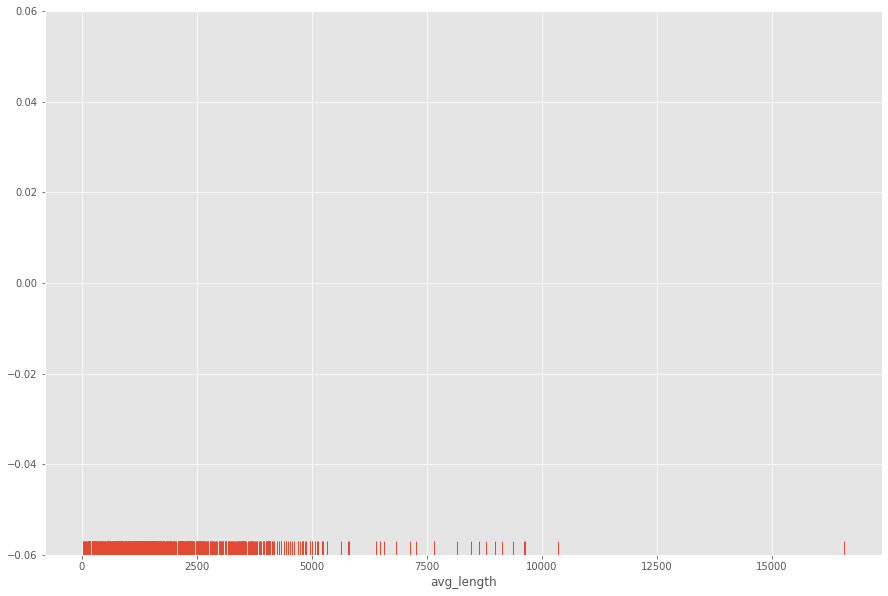

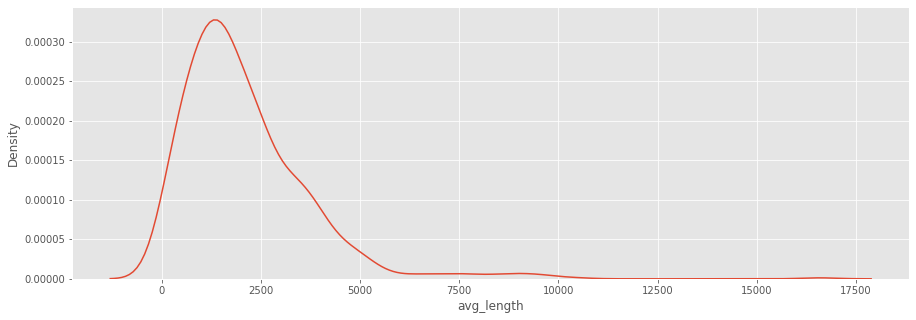

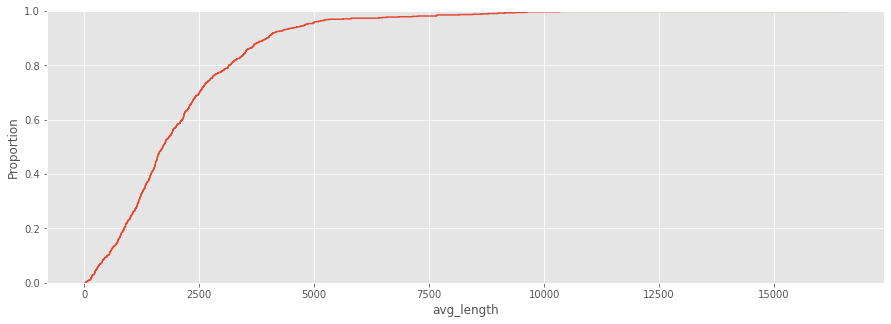

In [122]:
bpsos.plot()

### Observations

In [123]:
df = bpsos.df
limit = 200

In [124]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

426    Chúc cho đại hội đảng toàn quốc sắp tới được V...
566    ĐÀ LẠT - 20 năm nhìn lại của nhiếp ảnh Trương ...
581    Nếu không phải là người cách mạng vô sản thì s...
694       Tình cảm công an với tội phạm thật khăng khít🙈
701    Xin lỗi được thì Lê Văn Luyện đâu cần ở tù?\n\...
703    Ông T. bị tố nhiều lần dùng địa vị xã hội của ...
717    Quân Lệnh Cuối Cùng- Tưởng Nhớ Ngũ Hổ Tướng Củ...
723    Nhớ Chị\n\nHôm nay là ngày Sinh nhật của chị v...
740    Đăng để biết thêm về cái 4 tốt 16 chữ vàng của...
755    Nguyễn Văn Tráng chính thức bị truy nã😳\n\nPhả...
796    Sáng nay ảnh buồn lắm, tâm tư lắm. Thấy ảnh tâ...
799    Cấp báo-cấp báo: thêm 2 người nữa từ bỏ đảng C...
800    Tiếp tục bà con ơi🤣 vui như trẩy hội\n\nTôi, T...
801    Thu này buồn hẳn mấy thu qua\nBỏ đảng tin lan ...
821    Đảng trao một nữa búa liềm\nMà dân mất cả bạc ...
825    Đảng bảo là 6 ngày nữa bỏ phiếu kín lựa chọn c...
844    Sáng nay Hoàng A Mã đã nói kỷ luật Bắc Son mới...
862    Hôm nay là ngày 29-09 là

In [125]:
for post in df[df['avg_length'] < limit ]['content']:
    print(post)
    print('-----------------------')

Chúc cho đại hội đảng toàn quốc sắp tới được Vạn sự như Ý❤️
-----------------------
ĐÀ LẠT - 20 năm nhìn lại của nhiếp ảnh Trương Ngọc Thuỵ.

Tôi tự hỏi, người cộng sản từ rừng ra, đúng ra họ phải yêu rừng mới phải? Sao lại băm nát cả rừng xanh thế?
-----------------------
Nếu không phải là người cách mạng vô sản thì sẽ không thể nào có cuộc sống thần tiên thế này đâu😍

Chào mừng các bạn đến với thiên đường XHCN🙏🏽
-----------------------
Tình cảm công an với tội phạm thật khăng khít🙈
-----------------------
Xin lỗi được thì Lê Văn Luyện đâu cần ở tù?

Một lũ phường thảo khấu, phường quen thói trộm cướp, nói như CCC😏

Cướp xong xin lỗi là xong đó hả? Trả tiền lại cho dân đê bọn cướp😡
-----------------------
Ông T. bị tố nhiều lần dùng địa vị xã hội của mình để ép chị H. và chị Y. quan hệ tình dục với mình. Lại là đảng viên ưu tú với đảng nhưng lại khốn nạn với dân😡
-----------------------
Quân Lệnh Cuối Cùng- Tưởng Nhớ Ngũ Hổ Tướng Của Việt Nam Cộng Hòa Đã Tuẫn Tiết Trong Ngày 30 Tháng 

In [126]:
limit = 10000

In [127]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[1])

249    Nỗi buồn của một tang gia!\n\nCả bệnh viện một...
831    TẤM THẺ BÀI CỦA CÔ BÁC SĨ VIVIAN LE\n\nCâu chu...
Name: content, dtype: object
--------------------



TẤM THẺ BÀI CỦA CÔ BÁC SĨ VIVIAN LE

Câu chuyện được bắt đầu vào sáng ngày 23-3-1975

Sau khi chồng và con trai bị chết vì đạn pháo kích của Vc đồng thời bị thất lạc đứa con gái trong ngày di tản tại bãi biển Chu Lai, chị Buôn quấn quýt chạy khắp nơi để hỏi thăm về đứa con gái của mình... chị đã được một người chạy nạn cho biết:

"Con bé khoảng 9 hay 10 tuổi mặc cái áo xanh, quần đen, cổ có đeo cái thẻ bài của lính là con chị sao? Nó được một người trên ca-nô nhào xuống nước bơi vào vớt nó đưa lên ca-nô ra tầu lớn rồi. Thật là may mắn cho nó!"...

Lệ, đứa con thất lạc của chị Buôn được đưa lên tầu Hải quân với chiếc thẻ bài đeo toòng teng nơi ngực. Người ta thấy có khắc tên: Lê văn Buôn Số quân:.... Họ hỏi Lệ. Lệ nói đó là tên ba nó, ba Buôn của nó, bị lọt lại với má và ba đứa em tại bãi biển Chu Lai. Mới đầu Lệ sụt sùi k

### Run Preprocessing method

In [128]:
# 200 - 10000
# ...
bpsos.preprocess()

Enter < limit:200
Enter > limit:10000


### Save

In [129]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.csv		 khoi8406.pickle    thanhnienconggiao.csv
bpsos.pickle		 phamminhvu.pickle  thanhnienconggiao.pickle
chantroimoi.csv		 rfa_fixed.csv	    viettan.csv
chantroimoi.pickle	 rfa.pickle	    viettan_fb.csv
giaochucchuvanan.pickle  sbtn.csv	    viettan_fb.pickle
khoi8406.csv		 sbtn.pickle	    viettan.pickle


In [130]:
bpsos.df.iloc[1]['content']

'Người Việt Nam từ khi nào lại tàn nhẫn thế?\n\nĐọc lời trần tình con gái Mục sư Tân - Loan, cùng xin lỗi kèm cái cúi đầu và mong mọi người tha thứ Mục sư Tân, thật xót xa, và cay đắng, vì đằng sau đó là những chuỗi ngày bị dư luận tấn công không ngơi nghỉ, có nhiều bạn yêu đảng, yêu nhà nước còn tung lời đe dọa thiêu sống cả gia đình Mục sư.\n\nSao người Việt có thể nhẫn tâm, và tàn ác đến như thế?\n\nHỏi thăm qua hai người bạn một ở Mỹ, một ở Đức, vì hai quốc gia này có số người chết vì dịch và số người nhiễm trước đây thuộc top của thế giới. Họ ngạc nhiên vì tại Mỹ và tại Đức những trường hợp tương tự của vợ chồng Mục sư Tân-Loan cùng lắm chỉ là bị phạt tiền thôi, chứ chẳng ai bị khởi tố.\n\nVì Chính phủ Mỹ hay chính phủ Đức là chính phủ do dân bầu, để xảy ra tình trạng dịch bệnh mất kiểm soát như thế là trách nhiệm thuộc về chính phủ, chính phủ Mỹ hay Đức họ nhận thấy rõ điều đó cho nên họ sửa sai bằng cách cố gắng nghiên cứu tìm ra Vaccine nhanh chóng, kèm theo tăng phúc lợi xã hộ

In [131]:
bpsos.save_preprocess(os.getcwd() + "/phamminhvu")

In [132]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Giao chuc chu van an

### Define new instances

In [133]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [134]:
# viettan_ls = []
# df_ls = []

# for i in range(-4, -1):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     print(test.name)
#     test.read_csv()
#     df_ls.append(test.df)

bpsos = Dataframe('/1/' + 'GiaoChucChuVanAn.csv', 1)
print(bpsos.name)
bpsos.read_csv()



# bpsos = Dataframe()
# bpsos.df = pd.concat(df_ls)

df = bpsos.df 
df

/1/GiaoChucChuVanAn.csv
df:       Unnamed: 0                                            content
0             0  Luân Lê\n27 tháng 5 lúc 16:34 ·\n\nVĂN TỪ CỦA ...
1             1  THẦY GIÁO THỂ HIỆN VĂN HÓA ĐẢNG?\n\nKhoảng Trờ...
2             2  Nguyễn Đình Cống\n3 giờ ·\nTHƯ TRẢ LỜI CỦA BỘ ...
3             3  https://www.youtube.com/watch?v=rXQQ-oXEnFs\n\...
4             4  Video thứ 10 được thực hiện nhân một thành tựu...
..          ...                                                ...
282         282  Xin được giới thiệu bài viết của đài Á Châu Tự...
283         283  VIDEO PHÁT BIỂU CỦA NHÀ GIÁO PHẠM TOÀN\n\nPhát...
284         284  VIDEO PHÁT BIỂU CỦA GIÁO SƯ NGUYỄN ĐÌNH CỐNG\n...
285         285                                                NaN
286         286  Kính mời mọi người theo dõi cuộc trao đổi của ...

[287 rows x 2 columns]


,content,label,avg_length
0,Luân Lê\n27 tháng 5 lúc 16:34 ·\n\nVĂN TỪ CỦA ...,1,1873
1,THẦY GIÁO THỂ HIỆN VĂN HÓA ĐẢNG?\n\nKhoảng Trờ...,1,644
2,Nguyễn Đình Cống\n3 giờ ·\nTHƯ TRẢ LỜI CỦA BỘ ...,1,1384
3,https://www.youtube.com/watch?v=rXQQ-oXEnFs\n\...,1,157
4,Video thứ 10 được thực hiện nhân một thành tựu...,1,374
...,...,...,...
281,Mọi người quân tâm đến giáo dục hãy bình luận ...,1,370
282,Xin được giới thiệu bài viết của đài Á Châu Tự...,1,147
283,VIDEO PHÁT BIỂU CỦA NHÀ GIÁO PHẠM TOÀN\n\nPhát...,1,643
284,VIDEO PHÁT BIỂU CỦA GIÁO SƯ NGUYỄN ĐÌNH CỐNG\n...,1,806


### Content Filter

In [135]:
temp = df[df['content'].str.contains("CS|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|công an|" + 
        "quan chức|cướp|nhà nước|tự do|dối|thất bại|bê bối|chính trị|chính quyền|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(bpsos.name)
bpsos.df = temp
bpsos.df

/1/GiaoChucChuVanAn.csv


,content,label,avg_length
1,THẦY GIÁO THỂ HIỆN VĂN HÓA ĐẢNG?\n\nKhoảng Trờ...,1,644
2,Nguyễn Đình Cống\n3 giờ ·\nTHƯ TRẢ LỜI CỦA BỘ ...,1,1384
10,https://www.youtube.com/watch?v=5Lp6MGINBIs\n\...,1,146
11,https://www.youtube.com/watch?v=0b5RsM8Ob_A\n\...,1,157
13,https://www.youtube.com/watch?v=0wTwAmx2axc\n\...,1,117
...,...,...,...
266,Vì sao nhà nước CSVN không đưa cuộc chiến tran...,1,914
271,GIÁO SƯ NGUYỄN ĐÌNH CỐNG TUYÊN BỐ TỪ BỎ ĐẢNG C...,1,1080
273,http://tiengnoicongdan.blogspot.com/2016/01/hi...,1,423
282,Xin được giới thiệu bài viết của đài Á Châu Tự...,1,147


In [136]:
for post in bpsos.df['content'].iloc[:60]:
    print(post)
    print("---------------------")
# print(bpsos.df['content'].iloc[:-1])

THẦY GIÁO THỂ HIỆN VĂN HÓA ĐẢNG?

Khoảng Trời Có Mưa
1 tháng 5 lúc 23:02 ·

Không biết với những hành vi như thế của một giáo viên đại diện ngành giáo dục thì trách nhiệm trước pháp luật và toàn xã hội sẽ làKhác tạm đình chỉ giảng dạy hay là phải xử lý hình sự?!
Thầy giáo mà cứ ngỡ m.a cô!

https://www.facebook.com/khoangtroicomua1/posts/330266272001555

Khoảng Trời Có Mưa
1 tháng 5 lúc 18:02 ·

Không biết với những hành vi như thế của một giáo viên đại diện ngành giáo dục thì trách nhiệm trước pháp luật và toàn xã hội sẽ là tạm đình chỉ giảng dạy hay là phải xử lý hình sự?!
Thầy giáo mà cứ ngỡ m.a cô!

Like Page 👉 👉

Khoảng Trời Có Mưa
---------------------
Nguyễn Đình Cống
3 giờ ·
THƯ TRẢ LỜI CỦA BỘ TRƯỞNG
Tôi vừa nhận thư trả lời của Bộ trưởng, chép lên đây để các ban xem.
Kính gửi Thầy Nguyễn Đình Cống
Xin trân trọng cảm ơn những lời thẳng thắn, chân thànhKhác và trách nhiệm của Thầy. Thầy và các Thầy Cô đồng nghiệp khác nếu có các ý kiến tư vấn gì cụ thể hơn xin lại gửi vào địa ch

In [137]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[0])

Luân Lê
27 tháng 5 lúc 16:34 ·

VĂN TỪ CỦA NHỮNG KẺ VÔ LẠI

Những kẻ chẳng còn nhân tính, nhưng, lại là những cái nhưng chất chứa nỗi xót xa và phẫn nộ, những bộ mặt gánh vác trọng trách “gây dựng tâm hồn” sonKhác phết rạng rỡ vẻ ngoài “nhân văn” lại là những kẻ vô lại vì tâm hồn đã lấm bẩn đầy bùn đất.
Các câu chữ được bày ra chỉ cho thấy họ không chỉ tàn bạo với đồng nghiệp, mà họ còn đang thực hiện một cuộc lật đổ về nhân tính con người, khi đang nhân danh sự giáo dục.
“Đù phe mình không”, hay “dập cho chết bà nhà nó đi”, một cách vui thú, trong một đoạn thoại ngắn ngủi giữa vài gương mặt nhà giáo với nhau. Và người thứ ba vắng mặt trở thành tiêu ngắm để bọn họ thực hành những sự triệt hạ mà chúng đang được thảo bàn trong sự tàn nhẫn hết sức lạnh lùng.
Nó không phải một sự hy hữu, nó trở thành phương cách phổ biến cho nỗi sinh tồn trong xã hội hiện thời - phe (cánh) nào; và sự truy diệt.
https://www.facebook.com/HienTheVoHinh/posts/2965520047025094

Luân Lê
27 tháng 5 lúc 11:34 ·

V

### Plot distribution

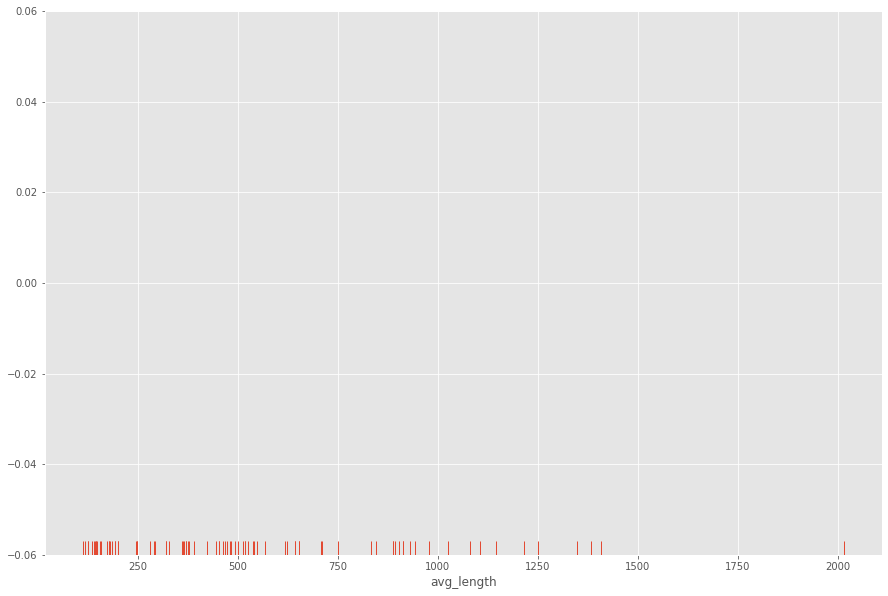

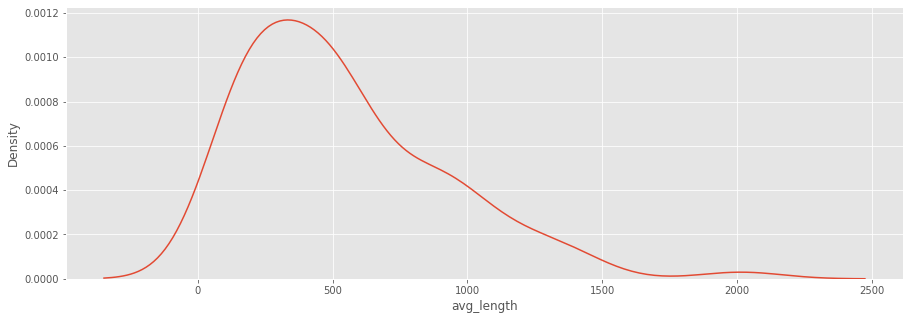

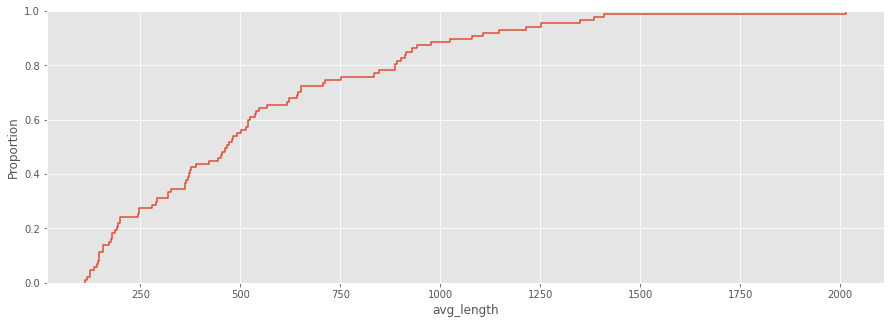

In [138]:
bpsos.plot()

### Observations

In [139]:
df = bpsos.df
limit = 300

In [140]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

10     https://www.youtube.com/watch?v=5Lp6MGINBIs\n\...
11     https://www.youtube.com/watch?v=0b5RsM8Ob_A\n\...
13     https://www.youtube.com/watch?v=0wTwAmx2axc\n\...
18     https://www.youtube.com/watch?v=w2lvBG9ykiM\n\...
27     https://www.facebook.com/nguyentrongmai55/post...
31     https://www.voatiengviet.com/a/thu-truong-bo-g...
42     https://www.facebook.com/anh.toi.14224/posts/1...
50     Học chống tham nhũng, chống ai? Chống đảng à?\...
61     Sở giáo dục Hà Tĩnh tiếp khách hơn 3 tỷ đồng 1...
62     Bộ trưởng bộ giáo dục thiếu cả đạo đức lẫn trí...
99     https://chantroimoimedia.com/2018/08/14/kinh-d...
102    Xã hội Việt Nam dưới sự lãnh đạo "toàn diện, t...
104    Giáo viên phá thai để góp phần giữ "thành tích...
117    https://www.youtube.com/watch?v=3Erdrkg_XBQ\n\...
122    Tốt nghiệp đại học ở chốn thiên đường XHCN !\n...
140    Sáng nay ngày 24/8/2017 (2/7 âm lịch) nhân dịp...
142    CNMLN - Bạo lực cách mạng đang được học sinh t...
146    Thầy Dương Tuấn Ngọc giả

In [141]:
for post in df[df['avg_length'] < limit ]['content']:
    print(post)
    print('-----------------------')

https://www.youtube.com/watch?v=5Lp6MGINBIs

YOUTUBE.COM
TRÒN 1 NĂM NGÀY THẦY GIÁO, TÙ NH N LƯƠNG T M ĐÀO QUANG THỰC QUA ĐỜI TRONG NHÀ TÙ CỘNG SẢN
-----------------------
https://www.youtube.com/watch?v=0b5RsM8Ob_A

YOUTUBE.COM
KTV tối 25/11: Danh sách lãnh đạo CSVN trình độ cấp 2, mua bằng TS giả được cất nhắc ghế quan trọng?
-----------------------
https://www.youtube.com/watch?v=0wTwAmx2axc

YOUTUBE.COM
Cải cách cái đầu quan chức trước khi cải cách sách giáo khoa
-----------------------
https://www.youtube.com/watch?v=w2lvBG9ykiM

YOUTUBE.COM
KTV Live trưa 26/9: Lửa ĐH13 lan đến ĐH Tôn Đức Thắng & những bê bối ở Tổng liên đoàn LĐ?
-----------------------
https://www.facebook.com/nguyentrongmai55/posts/1184396571745879

BAOMOI.COM
Hơn 2.200 sinh viên Trường ĐH Công nghiệp TP.HCM tự ý bỏ học

Nguyễn Trọng Mai
16 tháng 12, 2019 lúc 18:28 ·

Đến CNXH rồi
-----------------------
https://www.voatiengviet.com/a/thu-truong-bo-gddt-le-hai-an-tu-vong-do-nga-tu-tang-8/5127670.html

VOATIENGVIE

In [142]:
limit = 2000

In [143]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

20    KHÔNG BIẾT NHỤC SAO CÒN TỰ HÀO?\n\nĐảng csVn ...
Name: content, dtype: object
--------------------



KHÔNG BIẾT NHỤC SAO CÒN TỰ HÀO?

Đảng csVn đưa vào sách giáo khoa dạy cho các thế hệ trẻ rằng: "đất nước ta giàu và đẹp. Có rừng vàng, biển bạc, khoáng sản, dầu mỏ....bao la". Rồi đảng vỗ ngực tự hào vì thếKhác hệ của họ đã bán đổ, bán tháo, bán sạch sành sanh các tài nguyên mà tổ tiên đã để lại ấy. Lý do tự hào của họ đưa ra là: thế hệ cháu con sẽ không còn dựa vào tài nguyên thiên nhiên nữa, mà con đường duy nhất muốn tồn tại là phải học?

Ôi! Ăn hết phần của con cháu mà tự hào sao mấy ông cộng sản? Trên đời này có loài gì dành ăn với con cháu mà vỗ ngực tự hào hả trời? Thử quan sát xem loài Ong, loài Kiến còn biết tìm kiếm tích trữ lương thực về cho những ổ trứng chưa nở của chúng nữa là. Xem ra lương tri, trách nhiệm của đảng csVn còn không bằng loài côn trùng, chớ đừng nói là quang vinh, vĩ đại!

Lẽ ra, đảng các người phải biết nhục với con cháu vì thế hệ mình dành 

### Run Preprocessing method

In [144]:
# 300 - 10000
# ...
bpsos.preprocess()

Enter < limit:300
Enter > limit:10000


### Save

In [145]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.csv		 phamminhvu.csv		thanhnienconggiao.pickle
bpsos.pickle		 phamminhvu.pickle	viettan.csv
chantroimoi.csv		 rfa_fixed.csv		viettan_fb.csv
chantroimoi.pickle	 rfa.pickle		viettan_fb.pickle
giaochucchuvanan.pickle  sbtn.csv		viettan.pickle
khoi8406.csv		 sbtn.pickle
khoi8406.pickle		 thanhnienconggiao.csv


In [146]:
bpsos.df['content'].iloc[0]

'THẦY GIÁO THỂ HIỆN VĂN HÓA ĐẢNG?\n\nKhoảng Trời Có Mưa\n1 tháng 5 lúc 23:02 ·\n\nKhông biết với những hành vi như thế của một giáo viên đại diện ngành giáo dục thì trách nhiệm trước pháp luật và toàn xã hội sẽ làKhác tạm đình chỉ giảng dạy hay là phải xử lý hình sự?!\nThầy giáo mà cứ ngỡ m.a cô!\n\n\nKhoảng Trời Có Mưa\n1 tháng 5 lúc 18:02 ·\n\nKhông biết với những hành vi như thế của một giáo viên đại diện ngành giáo dục thì trách nhiệm trước pháp luật và toàn xã hội sẽ là tạm đình chỉ giảng dạy hay là phải xử lý hình sự?!\nThầy giáo mà cứ ngỡ m.a cô!\n\nLike Page 👉 👉\n\nKhoảng Trời Có Mưa'

In [147]:
bpsos.save_preprocess(os.getcwd() + "/giaochucchuvanan")

In [148]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Chinhtri vnexpress

### Define new instances

In [149]:
dataset_0

['vnexpress_thoisu_2.csv',
 'tinnoichinh.csv',
 'vnexpress_kinhdoanh.csv',
 'qdnd_dienbienhoabinh.csv',
 'vnexpress_phapluat.csv',
 'vnexpress_thoisu_1.csv',
 'qdnd_chinhtri.csv']

In [150]:
viettan_ls = []

for i in [0, 2, 3, 4, 5, 6]:
    test = Dataframe('/0/' + dataset_0[i], 0)
    print(test.name)
    test.read_csv()
    viettan_ls.append(test.df)

viettan= Dataframe('', 0)
viettan.df = pd.concat(viettan_ls)
df = viettan.df

print(df)
print(df.shape)

/0/vnexpress_thoisu_2.csv
df:        Unnamed: 0                                            content
0              0  Lãnh đạo quận Thủ Đức xây dựng không phép\nTP ...
1              1  Phó giám đốc Sở ở Đồng Tháp bị đình chỉ chức v...
2              2  Những mùa bão quét qua nhà giàn DK1\nTrước lúc...
3              3  19 học sinh nhập viện do hơi cay\nQuảng Ninh19...
4              4  Cô giáo dành nửa cuộc đời giúp trẻ khuyết tật\...
...          ...                                                ...
8487        8487  Trung vệ Bùi Tiến Dũng ký tặng ảnh gây quỹ giú...
8488        8488  Bão cấp 8 gần biển Đông\nChiều nay 11/2, áp th...
8489        8489  Tết sớm của sĩ quan gìn giữ hòa bình Việt Nam ...
8490        8490  Ba Thứ trưởng Ngoại giao nghỉ hưu\nBa Thứ trưở...
8491        8491  Ngư dân Hà Tĩnh trúng đậm mẻ cá thu\nKhoang tà...

[8492 rows x 2 columns]
/0/vnexpress_kinhdoanh.csv
df:        Unnamed: 0                                            content
0              0  Bitcoin lầ

### Content Filter

In [151]:
temp = df[df['content'].str.contains("CS|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|công an|" + 
        "quan chức|cướp|nhà nước|tự do|dối|thất bại|bê bối|chính trị|chính quyền|XHCN", regex = True, flags=re.IGNORECASE)]

# print(viettan.name)
viettan.df = temp
df = viettan.df
# temp.iloc[3].content
viettan.df

,content,label,avg_length
0,Lãnh đạo quận Thủ Đức xây dựng không phép\nTP ...,0,3284
1,Phó giám đốc Sở ở Đồng Tháp bị đình chỉ chức v...,0,2902
2,Những mùa bão quét qua nhà giàn DK1\nTrước lúc...,0,9709
3,19 học sinh nhập viện do hơi cay\nQuảng Ninh19...,0,582
4,Cô giáo dành nửa cuộc đời giúp trẻ khuyết tật\...,0,5349
...,...,...,...
3035,Thủ tướng Nguyễn Xuân Phúc dự Hội nghị tổng kế...,0,5759
3036,Chủ tịch Quốc hội Nguyễn Thị Kim Ngân chủ trì ...,0,2631
3037,Chủ tịch nước Trần Đại Quang dự chương trình n...,0,3147
3038,Ông Hầu A Lềnh giữ chức Phó chủ tịch - Tổng th...,0,4380


### Plot distribution

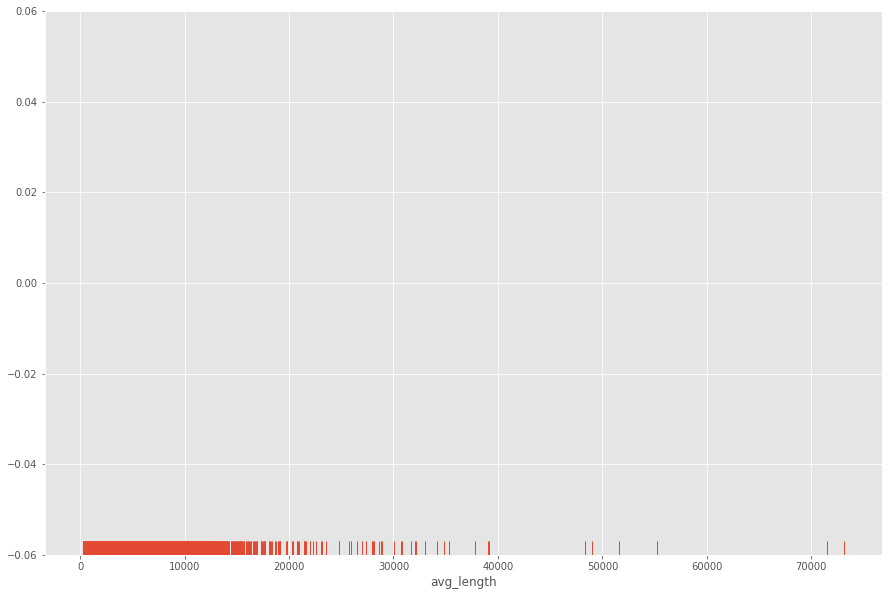

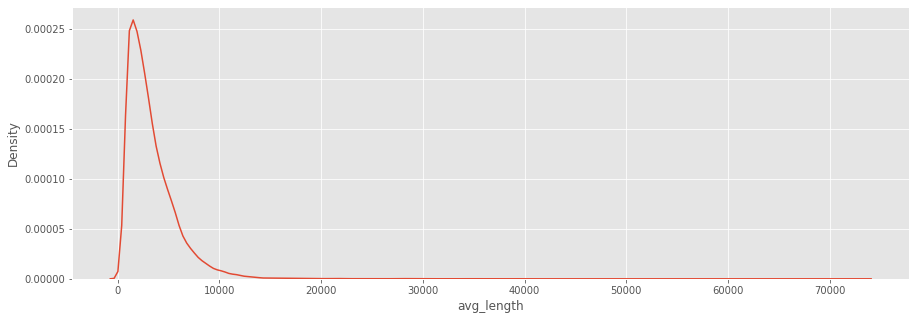

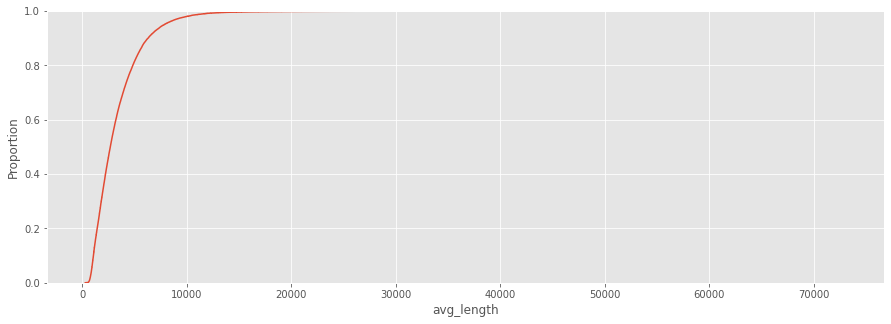

In [152]:
viettan.plot()

### Observations

In [153]:
limit = 400

In [154]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

5944    Ngập kéo dài, hơn nghìn hộ dân Hà Nội mất điện...
5993    Những khoảnh khắc ghi dấu thời điểm Hà Nội mở ...
8207    Đêm 'trống vỡ là yêu' giữa đại ngàn Trường Sơn...
937     Chuyên gia phân tích kịch bản chuyển đổi số ng...
1665    Cách doanh nghiệp nhỏ và vừa khai thác Hiệp đị...
3506    'Phát triển thành phố thông minh cần có sự hợp...
3811    DKRA Vietnam: 'Thị trường căn hộ Bình Dương nó...
4001    15 Thống đốc Ngân hàng Nhà nước qua các thời k...
5050    Núi nợ trăm năm của thế giới cao thêm vì Covid...
7933    10 người giàu nhất hành tinh\nNăm nay, Jeff Be...
8068    Khủng hoảng nợ toàn cầu có thể đang đến\nThế g...
215     8 khúc mắc về quyền kiểm soát của cha mẹ với c...
253     7 điều cần biết khi sử dụng mạng xã hội\nViết ...
352     Giải mã những ngộ nhận về biển số xe\nBiển số ...
528     4 'ngộ nhận' khi gặp tín hiệu đèn giao thông\n...
562     Giải mã những ngộ nhận về 'người thứ ba'\nĐánh...
607     Giải đáp những khúc mắc khi 'chung sống như vợ...
672     Giải m

In [155]:
limit = 45000

In [156]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

519     Chủ thuyết chính trị Việt Nam trong thời đại n...
560     Xây dựng Đảng là nhiệm vụ then chốt, có ý nghĩ...
2754    Báo cáo của Ban Chấp hành Trung ương khóa XII ...
716     Việt Nam là một trong những quốc gia tăng trưở...
1214    Dự kiến, năm 2019 là năm thứ hai liên tiếp đạt...
2664    Đánh giá bổ sung kết quả phát triển kinh tế-xã...
Name: content, dtype: object
--------------------



Chủ thuyết chính trị Việt Nam trong thời đại ngày nay
QĐND - Chủ thuyết chính trị Việt Nam thời đại ngày nay là độc lập dân tộc gắn liền với chủ nghĩa xã hội dưới ngọn cờ lãnh đạo của Đảng Cộng sản Việt Nam trên nền tảng chủ nghĩa Mác - Lê-nin, tư tưởng Hồ Chí Minh phát triển từ hơn 80 năm nay và mãi từ nay về sau...
QĐND - Chủ thuyết chính trị Việt Nam thời đại ngày nay là độc lập dân tộc gắn liền với chủ nghĩa xã hội dưới ngọn cờ lãnh đạo của Đảng Cộng sản Việt Nam trên nền tảng chủ nghĩa Mác - Lê-nin, tư tưởng Hồ Chí Minh phát triển từ hơn 80 năm nay và mãi từ nay về sau.
I. Sự lựa chọn củ

### Run Preprocessing method

In [157]:
# 400 - 45000
# ...
viettan.preprocess()

Enter < limit:400
Enter > limit:45000


### Save

In [158]:
%cd ..
%cd preprocessed 
%cd 0/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/0
tinnoichinh.pickle  vnexpress_v2.pickle


In [159]:
print(viettan.df)

                                                content  label  avg_length
0     Lãnh đạo quận Thủ Đức xây dựng không phép\nTP ...      0        3284
1     Phó giám đốc Sở ở Đồng Tháp bị đình chỉ chức v...      0        2902
2     Những mùa bão quét qua nhà giàn DK1\nTrước lúc...      0        9709
3     19 học sinh nhập viện do hơi cay\nQuảng Ninh19...      0         582
4     Cô giáo dành nửa cuộc đời giúp trẻ khuyết tật\...      0        5349
...                                                 ...    ...         ...
3035  Thủ tướng Nguyễn Xuân Phúc dự Hội nghị tổng kế...      0        5759
3036  Chủ tịch Quốc hội Nguyễn Thị Kim Ngân chủ trì ...      0        2631
3037  Chủ tịch nước Trần Đại Quang dự chương trình n...      0        3147
3038  Ông Hầu A Lềnh giữ chức Phó chủ tịch - Tổng th...      0        4380
3039  Văn phòng Quốc hội triển khai nhiệm vụ năm 201...      0        3993

[30551 rows x 3 columns]


In [160]:
viettan.save_preprocess(os.getcwd() + "/vnexpress_v2")

In [161]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Tinnoichinh

### Define new instances

In [162]:
dataset_0

['vnexpress_thoisu_2.csv',
 'tinnoichinh.csv',
 'vnexpress_kinhdoanh.csv',
 'qdnd_dienbienhoabinh.csv',
 'vnexpress_phapluat.csv',
 'vnexpress_thoisu_1.csv',
 'qdnd_chinhtri.csv']

In [163]:
viettan_ls = []

for i in [-1]:
    test = Dataframe('/0/' + dataset_0[i], 0)
    print(test.name)
    test.read_csv()
    viettan_ls.append(test.df)

viettan= Dataframe('', 9)
viettan.df = pd.concat(viettan_ls)
df = viettan.df

print(df.shape)

/0/qdnd_chinhtri.csv
df:        Unnamed: 0                                            content
0              0  Khắc phục 2 khuynh hướng làm giảm “tuổi thọ” c...
1              1  Thủ tướng Phạm Minh Chính: Việc chống dịch Cov...
2              2  Chủ tịch nước Nguyễn Xuân Phúc: Nâng cao chất ...
3              3  Chủ tịch Quốc hội Vương Đình Huệ thăm Báo Nhân...
4              4  Thủ tướng Phạm Minh Chính: Sứ mệnh của những n...
...          ...                                                ...
3035        3035  Thủ tướng Nguyễn Xuân Phúc dự Hội nghị tổng kế...
3036        3036  Chủ tịch Quốc hội Nguyễn Thị Kim Ngân chủ trì ...
3037        3037  Chủ tịch nước Trần Đại Quang dự chương trình n...
3038        3038  Ông Hầu A Lềnh giữ chức Phó chủ tịch - Tổng th...
3039        3039  Văn phòng Quốc hội triển khai nhiệm vụ năm 201...

[3040 rows x 2 columns]
(3040, 3)


### Content Filter

In [164]:
temp = df[df['content'].str.contains("CS|đánh|tù|dân chủ|Cộng Sản|việt cộng|tội ác|kích động|đàn áp|Đảng|cai trị|tham nhũng|CSVN|nhà cầm quyền|giàu|tử vong|chủ nghĩa|chế độ|cán bộ|bầu cử|công an|" + 
        "quan chức|cướp|nhà nước|tự do|dối|thất bại|bê bối|chính trị|chính quyền|XHCN", regex = True, flags=re.IGNORECASE)]

print(viettan.name)
viettan.df = temp
df = viettan.df

viettan.df

,content,label,avg_length
0,Khắc phục 2 khuynh hướng làm giảm “tuổi thọ” c...,0,4838
1,Thủ tướng Phạm Minh Chính: Việc chống dịch Cov...,0,5595
2,Chủ tịch nước Nguyễn Xuân Phúc: Nâng cao chất ...,0,12639
3,Chủ tịch Quốc hội Vương Đình Huệ thăm Báo Nhân...,0,6574
4,Thủ tướng Phạm Minh Chính: Sứ mệnh của những n...,0,4897
...,...,...,...
3035,Thủ tướng Nguyễn Xuân Phúc dự Hội nghị tổng kế...,0,5759
3036,Chủ tịch Quốc hội Nguyễn Thị Kim Ngân chủ trì ...,0,2631
3037,Chủ tịch nước Trần Đại Quang dự chương trình n...,0,3147
3038,Ông Hầu A Lềnh giữ chức Phó chủ tịch - Tổng th...,0,4380


### Plot distribution

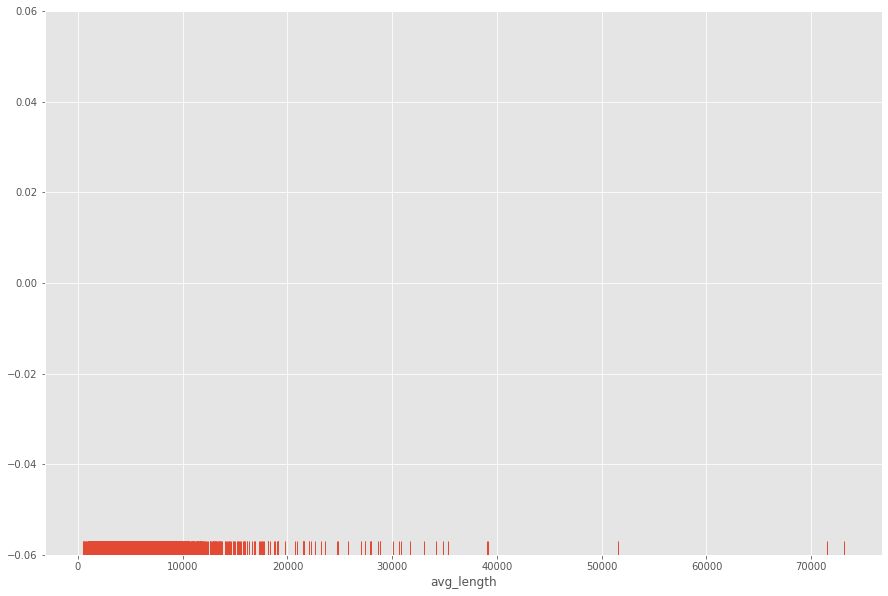

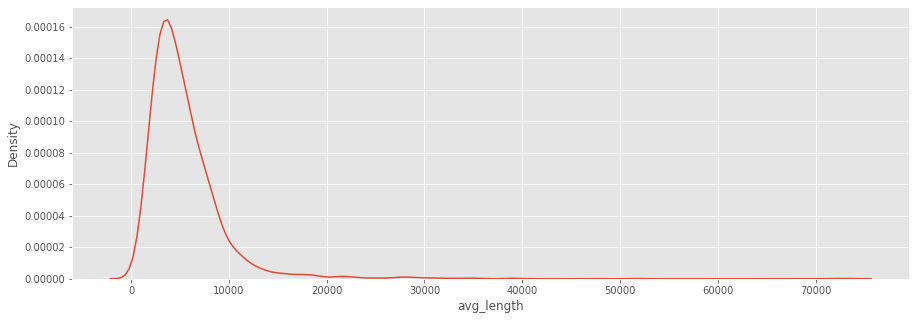

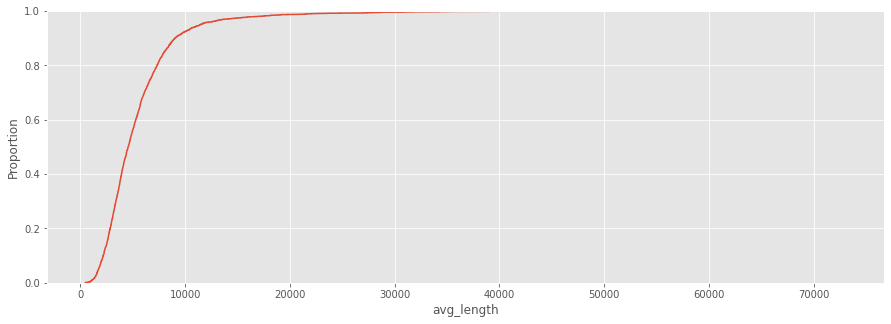

In [165]:
viettan.plot()

### Observations

In [166]:
limit = 320

In [167]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

Series([], Name: content, dtype: object)
--------------------





IndexError: ignored

In [168]:
limit = 48000

In [169]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

716     Việt Nam là một trong những quốc gia tăng trưở...
1214    Dự kiến, năm 2019 là năm thứ hai liên tiếp đạt...
2664    Đánh giá bổ sung kết quả phát triển kinh tế-xã...
Name: content, dtype: object
--------------------



Việt Nam là một trong những quốc gia tăng trưởng cao nhất trong khu vực và trên thế giới(*)
Theo chương trình kỳ họp, Chính phủ đã gửi đến Quốc hội 74 báo cáo và tờ trình về các lĩnh vực, trong đó có các báo cáo đánh giá đầy đủ, toàn diện tình hình thực hiện kế hoạch phát triển kinh tế-xã hội (KT-XH) năm 2020 và 5 năm 2016-2020; dự kiến kế hoạch phát triển KT-XH năm 2021 và phương hướng, nhiệm vụ 5 năm 2021-2025. Thay mặt Chính phủ, tôi xin trân trọng báo cáo Quốc hội và đồng bào, cử tri cả nước những nội dung chủ yếu như sau:
I. TÌNH HÌNH THỰC HIỆN KẾ HOẠCH PHÁT TRIỂN KT-XH NĂM 2020 VÀ 5 NĂM 2016-2020

		Chúng ta thực hiện nhiệm vụ phát triển KT-XH 5 năm 2016-2020 trong bối cảnh quốc tế, trong nước có nhiều thuận lợi nhưng cũng gặp không ít khó khăn, thách thức.

### Run Preprocessing method

In [170]:
# 750 - 48000
# ...
viettan.preprocess()

Enter < limit:750
Enter > limit:48000


### Save

In [171]:
%cd ..
%cd preprocessed 
%cd 0/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/0
tinnoichinh.pickle  vnexpress_v2.csv  vnexpress_v2.pickle


In [172]:
viettan.save_preprocess(os.getcwd() + "/tinnoichinh")

In [173]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


# Dataset summary

In [174]:
!ls

0  1  README.md


In [175]:
row = 0
sum_len = 0
df_ls = []
for data in os.listdir('./1/'):
    df = pd.read_csv('./1/' + data)
    df = df.drop(['Unnamed: 0'], axis = 1)
    if 'blue' in df.columns:
        df.rename(columns = {'blue': 'content'}, inplace = True)
    df['label'] = np.ones((df.shape)).astype('int')
    df['label'].astype('category')
    df = df.dropna()
    df['avg_length'] = df['content'].apply(len)

    row += df.shape[0]
    sum_len += np.sum(df['avg_length'])

    df_ls.append(df)


print("Rows: ", row)
print("Length: ", sum_len / row)

print(pd.concat(df_ls).duplicated('content').sum())

Rows:  25558
Length:  2506.2541669927223
500


In [176]:
row = 0
sum_len = 0
sum_ls = []
for data in os.listdir('./0/'):
    try: 
        with open("./0/" + data, "rb") as f:
            df = pickle.load(f)
    except:
        continue

    # df = df.drop(['Unnamed: 0'], axis = 1)
    # if 'blue' in df.columns:
        # df.rename(columns = {'blue': 'content'}, inplace = True)
    df['label'] = np.ones((df.shape)).astype('int')
    df['label'].astype('category')
    df = df.dropna()
    df['avg_length'] = df['content'].apply(len)

    row += df.shape[0]
    
    sum_ls.append(df)


final_df = pd.concat(sum_ls) 



print("Row: ", final_df.shape[0])

print("Avg length: ", np.median(final_df['avg_length']))

temp = final_df[final_df['avg_length'] < 20000]
print(temp.shape)

sns.kdeplot(temp['avg_length'])

ValueError: ignored